In [1]:
from itertools import product, permutations
import math
import numpy as np
from pathlib import Path
from plotnine import (
    ggplot,
    aes,
    theme, 
    element_text,
    stat_smooth,
    facet_wrap,
    geom_tile,
    geom_point,
    geom_histogram,
    geom_violin,
    geom_col,
    xlab,
    ylab,
    ggtitle,
    geom_line,
    geom_ribbon,
    geom_vline,
    geom_text,
    scale_x_log10,
    scale_x_reverse,
    geom_boxplot
)
import polars as pl
import torch
import functorch
from sklearn import linear_model


from sngrok.fourier import slow_sn_ft_1d, slow_sn_ft_2d, sn_fourier_basis, sn_fourier_basis_2d, calc_power
from sngrok.groups import generate_subgroup, Symmetric
from sngrok.permutations import Permutation
from sngrok.model import SnMLP
from sngrok.tableau import generate_partitions
from sngrok.irreps import SnIrrep

from confection import Config

In [2]:
from torch.nn.functional import relu
from copy import deepcopy


def loss_fn(logits, labels):
    if len(logits.shape) == 3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])
    return -1. * correct_log_probs


def calc_power_contributions(tensor, n):
    total_power = (tensor ** 2).mean(dim=0)
    group_order = math.factorial(n)
    fourier_transform = slow_sn_ft_1d(tensor, n)
    irrep_power = calc_power(fourier_transform, group_order)
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    val_data = pl.DataFrame(power_vals.detach().cpu().numpy(), schema=[f'dim{i}' for i in range(tensor.shape[1])])
    val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data, fourier_transform


def mean_ablate_one_column(model, linear_activations, index):
    
    act_means = relu(linear_activations).mean(0)
    
    acts = deepcopy(relu(linear_activations))
    acts[:, index] = act_means[index]
    
    logits = model.unembed(acts)
    
    return loss_fn(logits, targets).sum()




def perturb_acts(model, linear_activations, mu, sigma):
    mean = torch.full_like(linear_activations, mu)
    var = torch.full_like(linear_activations, sigma)
    
    acts = deepcopy(relu(linear_activations + torch.normal(mean, var)))

    logits = model.unembed(acts)
    
    return loss_fn(logits, targets).sum()


def eval_loss(model_fn, params, lperms, rperms, targets):
    logits = model_fn(params, lperms, rperms)
    return loss_fn(logits, targets).mean()


def full_ablations(model_seed):
    ckpt_dir = Path('/Users/dashiell/workspace/sn-grok/s5_40_small')
    run_name = f's5_40_{model_seed}'

    #whole_config = Config().from_disk('configs/s5_lr_5.toml')
    run_dir = ckpt_dir / run_name
    model_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
    run_data = pl.read_parquet(run_dir / f'data.parquet')
    lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
    rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
    targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()

    model = SnMLP.from_config(model_run['config'])
    model.load_state_dict(model_run['model'])

    logits, cache = model.run_with_cache(lperms, rperms)
    
    
    original_loss = loss_fn(logits, targets).mean()
    
    linear_acts = cache['hook_linear']
    
    perturbed_loss001 =  perturb_acts(model, linear_acts, 0.0, 0.1)
    perturbed_loss01 = perturb_acts(model, linear_acts, 0.0, 1.0)
    perturbed_loss11 = perturb_acts(model, linear_acts, 1.0, 1.0)
    perturbed_lossneg11 = perturb_acts(model, linear_acts, -1.0, 1.0)
    
    abs_logits = model.unembed(linear_acts.abs())
    abs_loss = loss_fn(abs_logits, targets).mean()
    
    full_sign_logits = model.unembed(relu(-1. * linear_acts))
    full_sign_loss = loss_fn(full_sign_logits, targets).mean()
    
    fmodel, params = functorch.make_functional(model)
    
    fparams = [deepcopy(p) for p in params]
    fparams[0] = -1.0 * params[0]
    
    left_sign_loss = eval_loss(fmodel, fparams, lperms, rperms, targets)
    
    fparams = [deepcopy(p) for p in params]
    fparams[1] = -1.0 * params[1]
    
    right_sign_loss = eval_loss(fmodel, fparams, lperms, rperms, targets)
    
    return {
        'model_seed': model_seed,
        'original_loss': original_loss.item(),
        'full_sign_loss': full_sign_loss.item(),
        'abs_loss': abs_loss.item(),
        'left_sign_loss':  left_sign_loss.item(),
        'right_sign_loss': right_sign_loss.item(),
        'perturbed_loss_mean0_var1': perturbed_loss01.item(),
        'perturbed_loss_mean0_var0.1': perturbed_loss001.item(),
        'perturbed_loss_mean1_var1': perturbed_loss11.item(),
        'perturbed_loss_mean-1_var1': perturbed_lossneg11.item(),
    }



def fourier_basis_to_df(tensor, n, layer):
    group_order, num_irreps, fn_dim = tensor.shape
    all_partitions = generate_partitions(n)
    permutations = Permutation.full_group(n)
    assert len(permutations) == group_order
    assert len(all_partitions) == num_irreps
    
    long_values = tensor.reshape((-1, fn_dim))
    group_col= []
    for s in permutations:
        group_col += [str(s.sigma)] * num_irreps
    part_col = [str(p) for p in all_partitions] * group_order
    assert len(group_col) == len(part_col) and len(group_col) == long_values.shape[0]
    val_data = pl.DataFrame(long_values.detach().numpy(), schema=[f'dim{i}' for i in range(fn_dim)])
    sn_metadata = pl.DataFrame({'layer': [layer] * len(group_col), 'permutation': group_col, 'irrep': part_col})
    return pl.concat([sn_metadata, val_data], how='horizontal')
    



In [3]:
ablation_data = []

for i in range(128):
    ablation_data.append(full_ablations(i))




NameError: name 'targets' is not defined

In [311]:
loss_data = pl.DataFrame(ablation_data, orient='row')

In [321]:
loss_data.columns

['model_seed',
 'original_loss',
 'full_sign_loss',
 'abs_loss',
 'left_sign_loss',
 'right_sign_loss',
 'perturbed_loss_mean0_var1',
 'perturbed_loss_mean0_var0.1',
 'perturbed_loss_mean1_var1',
 'perturbed_loss_mean-1_var1']

In [331]:
"""
    .with_columns(
        full_sign_loss = (pl.col('full_sign_loss') - pl.col('original_loss')),
        abs_loss = (pl.col('abs_loss') - pl.col('original_loss')),
        left_sign_loss = (pl.col('left_sign_loss') - pl.col('original_loss')),
        right_sign_loss = (pl.col('right_sign_loss') - pl.col('original_loss')),
        pert_mean0_var1 = (pl.col('perturbed_loss_mean0_var1') - pl.col('original_loss')),
        pert_mean0_var01 = (pl.col('perturbed_loss_mean0_var0.1') - pl.col('original_loss')),
        pert_mean1_var1 = (pl.col('perturbed_loss_mean1_var1') - pl.col('original_loss')),
        pert_meanneg1_var1 = (pl.col('perturbed_loss_mean-1_var1') - pl.col('original_loss')),
    )
    .select(pl.exclude(['perturbed_loss_mean-1_var1', 'perturbed_loss_mean0_var0.1', 'original_loss']))
    """

(
    loss_data
    
    .rename({
        'perturbed_loss_mean0_var1': 'pert_mean0_var1',
        'perturbed_loss_mean0_var0.1': 'pert_mean0_var01',
        'perturbed_loss_mean1_var1': 'pert_mean1_var1',
        'perturbed_loss_mean-1_var1': 'pert_mean-1_var1'
    })
    .melt(id_vars='model_seed')
    .groupby('variable')
    .agg(
        min_loss = pl.col('value').min(),
        mean_loss = pl.col('value').mean(),
        max_loss = pl.col('value').max(),
        median_loss = pl.col('value').median(),
        std_loss = pl.col('value').std(),
        loss05 = pl.col('value').quantile(0.05),
        loss10 = pl.col('value').quantile(0.10),
        loss20 = pl.col('value').quantile(0.20),
        loss40 = pl.col('value').quantile(0.40),
        loss60 = pl.col('value').quantile(0.60),
        loss80 = pl.col('value').quantile(0.80),
        loss90 = pl.col('value').quantile(0.90),
        loss95 = pl.col('value').quantile(0.95),
    )
    .sort('variable')
    
)

variable,min_loss,mean_loss,max_loss,median_loss,std_loss,loss05,loss10,loss20,loss40,loss60,loss80,loss90,loss95
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""abs_loss""",3.6935e-13,1.3437e-7,0.000017,7.5984e-13,0.000001,3.8773e-13,3.9673e-13,4.3338e-13,5.6712e-13,1.3567e-12,1.6270e-11,4.1923e-10,1.5508e-8
"""full_sign_loss…",0.000002,0.000012,0.000356,0.000003,0.000038,0.000002,0.000002,0.000002,0.000002,0.000003,0.000005,0.00002,0.000088
"""left_sign_loss…",22.387097,36.456188,49.092482,33.457984,7.71131,25.886119,28.316595,31.824007,32.130365,34.934698,48.825938,48.935119,48.96572
"""original_loss""",0.000002,0.000013,0.000385,0.000003,0.000043,0.000002,0.000002,0.000002,0.000002,0.000003,0.000005,0.000014,0.000082
"""pert_mean-1_va…",30.45154,158.677723,847.529564,97.403016,157.758512,43.104001,49.35093,58.439496,79.802594,117.11341,214.220038,341.014238,537.913583
"""pert_mean0_var…",0.042652,0.24533,6.934252,0.055548,0.783041,0.043267,0.043597,0.044439,0.053253,0.061383,0.107871,0.281854,1.540468
"""pert_mean0_var…",24.845258,149.646838,1048.181772,76.469307,174.445352,34.488596,41.191023,46.324083,57.590399,106.101852,213.251065,337.904491,601.970898
"""pert_mean1_var…",457.289171,1816.878696,5762.309167,1491.19239,1104.614869,621.974366,764.050708,906.150496,1207.422572,1773.709002,2516.149589,3253.465965,4236.305098
"""right_sign_los…",22.360449,36.455479,49.092484,33.46395,7.711374,25.882981,28.316306,31.821333,32.112196,34.934149,48.825918,48.935119,48.965724


In [332]:
1.3e-6


1.3e-06

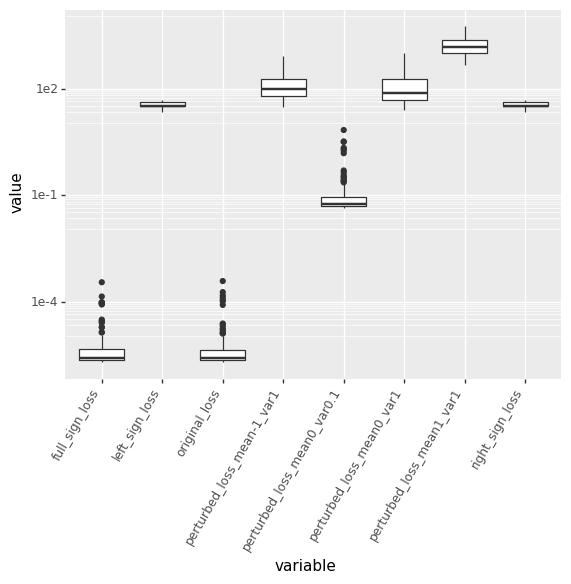

<ggplot: (375101233)>

In [317]:
from plotnine import scale_y_log10

(
    ggplot(
        loss_data.select(pl.exclude('abs_loss')).melt(id_vars='model_seed'), 
        aes(x='variable', y='value')
    ) 
    + geom_boxplot() 
    + scale_y_log10()
    + theme(axis_text_x=element_text(rotation=60, hjust=1))
)

In [4]:
def fourier_stats(model_seed):
    ckpt_dir = Path('/Users/dashiell/workspace/sn-grok/s5_40_small')
    run_name = f's5_40_{model_seed}'
    S5 = Symmetric(5)

    #whole_config = Config().from_disk('configs/s5_lr_5.toml')
    run_dir = ckpt_dir / run_name
    model_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
    run_data = pl.read_parquet(run_dir / f'data.parquet')
    lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
    rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
    targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()
    
    config = model_run['config']
    embed_dim = config['embed_dim']

    model = SnMLP.from_config(model_run['config'])
    model.load_state_dict(model_run['model'])

    logits, cache = model.run_with_cache(lperms, rperms)
    
    W = model.linear.weight

    lpower_df, llinear_ft = calc_power_contributions(model.lembed.weight @ W[:, :embed_dim].T, 5)
    rpower_df, rlinear_ft = calc_power_contributions(model.rembed.weight @ W[:, embed_dim:].T, 5)
    unembed_power_df, unembed_ft = calc_power_contributions(model.unembed.weight, 5)
    num_rows = lpower_df.shape[0]
    
    lpower_df.insert_at_idx(0, pl.Series('layer', ['left_linear'] * num_rows))
    rpower_df.insert_at_idx(0, pl.Series('layer', ['right_linear'] * num_rows))
    unembed_power_df.insert_at_idx(0, pl.Series('layer', ['unembed'] * num_rows))
    power_df = pl.concat([lpower_df, rpower_df, unembed_power_df], how='vertical').melt(id_vars=['layer', 'irrep'])
    
    llinear_decomp = sn_fourier_basis(llinear_ft, S5)
    rlinear_decomp = sn_fourier_basis(rlinear_ft, S5)
    unembed_decomp = sn_fourier_basis(unembed_ft, S5)
    
    llinear_df = fourier_basis_to_df(llinear_decomp, 5, 'left_linear')
    rlinear_df = fourier_basis_to_df(rlinear_decomp, 5, 'right_linear')
    unembed_df = fourier_basis_to_df(unembed_decomp, 5, 'unembed')
        
    
    return llinear_df, rlinear_df, unembed_df, power_df 
    


In [4]:
def gini_over_time_ablations(model_seed):
    ckpt_dir = Path('/Users/dashiell/workspace/sn-grok/s5_40_small')
    run_name = f's5_40_{model_seed}'

    #whole_config = Config().from_disk('configs/s5_lr_5.toml')
    run_dir = ckpt_dir / run_name
    model_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
    run_data = pl.read_parquet(run_dir / f'data.parquet')
    lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
    rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
    targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()

    model = SnMLP.from_config(model_run['config'])
    model.load_state_dict(model_run['model'])

    logits, cache = model.run_with_cache(lperms, rperms)
    
    
    original_loss = loss_fn(logits, targets).mean()
    
    linear_acts = cache['hook_linear']
    
    abs_logits = model.unembed(linear_acts.abs())
    abs_loss = loss_fn(abs_logits, targets).mean()
    
    full_sign_logits = model.unembed(relu(-1. * linear_acts))
    full_sign_loss = loss_fn(full_sign_logits, targets).mean()
    
    fmodel, params = functorch.make_functional(model)
    
    fparams = [deepcopy(p) for p in params]
    fparams[0] = -1.0 * params[0]
    
    left_sign_loss = eval_loss(fmodel, fparams, lperms, rperms, targets)
    
    fparams = [deepcopy(p) for p in params]
    fparams[1] = -1.0 * params[1]
    
    right_sign_loss = eval_loss(fmodel, fparams, lperms, rperms, targets)
    
    return {
        'model_seed': model_seed,
        'original_loss': original_loss.item(),
        'full_sign_loss': full_sign_loss.item(),
        'abs_loss': abs_loss.item(),
        'left_sign_loss':  left_sign_loss.item(),
        'right_sign_loss': right_sign_loss.item()
    }
    


In [5]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

In [6]:
gini(np.array([0.000000001, 0.001, 0.01, 0.01, 0.01, 0.1, 0.868999999]))

0.8014280087146797

In [11]:
llinear_df, rlinear_df, unembed_df, power_df = fourier_stats(36)

In [12]:
var_df = (
    llinear_df
    .melt(id_vars=['layer', 'permutation', 'irrep'])
    .groupby(['layer', 'permutation', 'variable'])
    .agg(pl.col('value').sum())
    .groupby(['layer', 'variable'])
    .agg([
        pl.col('value').mean().alias('mean'),
        pl.col('value').min().alias('min'),
        pl.col('value').max().alias('max'),
        pl.col('value').var().alias('full_var'),
    ])
    .sort('full_var')
)



In [13]:
from functools import reduce


s4_subgroups = {
    "order": 12,
    "copies": 5,
    "generators": [
        [(0, 2, 3, 4, 1), (0, 2, 1, 3, 4)], #1 fix 0
        [(2, 1, 3, 4, 0), (2, 1, 0, 3, 4)], #2 fix 1
        [(1, 3, 2, 4, 0), (1, 0, 2, 3, 4)], #3 fix 2
        [(1, 2, 4, 3, 0), (1, 0, 2, 3, 4)], #4 fix 3
        [(1, 2, 3, 0, 4), (1, 0, 2, 3, 4)], #5 fix 4
    ]
}

a4_subgroups = {
    "order": 12,
    "copies": 5,
    "generators": [
        [(0, 2, 1, 4, 3), (0, 3, 1, 2, 4)], # 1 fix 0
        [(2, 1, 0, 4, 3), (0, 1, 4, 2, 3)], # 2 fix 1
        [(1, 0, 2, 4, 3), (3, 0, 2, 1, 4)], # 3 fix 2
        [(1, 0, 4, 3, 2), (2, 0, 1, 3, 4)], # 4 fix 3
        [(1, 0, 3, 2, 4), (2, 0, 1, 3, 4)], # 5 fix 4

    ]
}

def union(cosets):
    if len(cosets) == 0:
        return cosets
    else:
        return reduce(lambda x, y: set(x).union(set(y)), cosets)

def get_cosets(subgroup):
    S5 =  Permutation.full_group(5)
    all_s5 = set([s.sigma for s in S5])
    perms = [Permutation(s) for s in subgroup]
    cosets = set()
    while union(cosets) != all_s5:
        left = S5.pop()
        coset = tuple(sorted([(left * s).sigma for s in perms]))
        cosets.add(coset)
    return cosets



def _coset_join(df1, df2):
    return df1.join(df2, on='permutation', how='inner')


def _coset_df(cosets, index, sg_name):
    data = []
    
    for cos in cosets:
        rep = str(cos[0])
        data.extend([{'permutation': str(c), 'subgroup': f'{sg_name}_{index}', f'coset_rep': rep} for c in cos])
    return pl.DataFrame(data)


def get_left_cosets(subgroup, full_n):
    Sn =  Permutation.full_group(full_n)
    all_sn = set([s.sigma for s in Sn])
    perms = [Permutation(s) for s in subgroup]
    cosets = set()
    while union(cosets) != all_sn:
        left = Sn.pop()
        coset = tuple(sorted([(left * s).sigma for s in perms]))
        cosets.add(coset)
    return cosets



def get_right_cosets(subgroup, full_n):
    Sn =  Permutation.full_group(full_n)
    all_sn = set([s.sigma for s in Sn])
    perms = [Permutation(s) for s in subgroup]
    cosets = set()
    while union(cosets) != all_sn:
        right = Sn.pop()
        coset = tuple(sorted([(s * right).sigma for s in perms]))
        cosets.add(coset)
    return cosets



def make_left_coset_rep_df(subgroups, n, sg_name):
    data = []
    
    for i, sg in enumerate(subgroups):
        cosets = list(get_left_cosets(sg, n))
        data.append(_coset_df(cosets, i, sg_name))
    
    return reduce(_coset_join, data)


def make_right_coset_rep_df(subgroups, n, sg_name):
    data = []
    
    for i, sg in enumerate(subgroups):
        cosets = list(get_right_cosets(sg, n))
        data.append(_coset_df(cosets, i, sg_name))
    
    return reduce(_coset_join, data)



def make_right_full_coset_df(subgroups, n, sg_name):
    data = []
    for i, sg in enumerate(subgroups):
        cosets = list(get_right_cosets(sg, n))
        data.append(_coset_df(cosets, i, sg_name))
    return pl.concat(data, how='vertical')


def make_left_full_coset_df(subgroups, n, sg_name):
    data = []
    for i, sg in enumerate(subgroups):
        cosets = list(get_left_cosets(sg, n))
        data.append(_coset_df(cosets, i, sg_name))
    return pl.concat(data, how='vertical')


frobenius_groups = {
    "order": 20,
    "copies": 6,
    "generators": [
        [(0, 2, 3, 4, 1), (1, 2, 4, 0, 3)],
        [(0, 2, 3, 4, 1), (1, 4, 3, 0, 2)],
        [(0, 2, 4, 1, 3), (1, 2, 3, 4, 0)],
        [(0, 2, 4, 1, 3), (1, 3, 4, 2, 0)],
        [(0, 3, 4, 2, 1), (1, 3, 0, 4, 2)],
        [(0, 3, 4, 2, 1), (1, 4, 0, 2, 3)]
    ]
    
}


In [14]:
all_a4_subgroups = [generate_subgroup(a4_gen) for a4_gen in a4_subgroups['generators']]
all_s4_subgroups = [generate_subgroup(s4_gen) for s4_gen in s4_subgroups['generators']]
all_frob_subgroups = [generate_subgroup(frob) for frob in frobenius_groups['generators']]

a4_right_coset_df = make_right_full_coset_df(all_a4_subgroups, 5, 'a4')
a4_left_coset_df = make_left_full_coset_df(all_a4_subgroups, 5, 'a4')

s4_right_coset_df = make_right_full_coset_df(all_s4_subgroups, 5, 's4')
s4_left_coset_df = make_left_full_coset_df(all_s4_subgroups, 5, 's4')

frob_right_coset_df = make_right_full_coset_df(all_frob_subgroups, 5, 'frob20')
frob_left_coset_df =  make_left_full_coset_df(all_frob_subgroups, 5, 'frob20')


In [15]:


full_right_coset_df = pl.concat([s4_right_coset_df, a4_right_coset_df, frob_right_coset_df], how='vertical')
full_left_coset_df = pl.concat([s4_left_coset_df, a4_left_coset_df, frob_left_coset_df], how='vertical')

In [16]:
full_right_coset_df

permutation,subgroup,coset_rep
str,str,str
"""(3, 0, 1, 2, 4…","""s4_0""","""(3, 0, 1, 2, 4…"
"""(3, 0, 1, 4, 2…","""s4_0""","""(3, 0, 1, 2, 4…"
"""(3, 0, 2, 1, 4…","""s4_0""","""(3, 0, 1, 2, 4…"
"""(3, 0, 2, 4, 1…","""s4_0""","""(3, 0, 1, 2, 4…"
"""(3, 0, 4, 1, 2…","""s4_0""","""(3, 0, 1, 2, 4…"
"""(3, 0, 4, 2, 1…","""s4_0""","""(3, 0, 1, 2, 4…"
"""(3, 1, 0, 2, 4…","""s4_0""","""(3, 0, 1, 2, 4…"
"""(3, 1, 0, 4, 2…","""s4_0""","""(3, 0, 1, 2, 4…"
"""(3, 1, 2, 0, 4…","""s4_0""","""(3, 0, 1, 2, 4…"


In [17]:
1920 / 120

16.0

In [18]:
left_base_df = llinear_df.melt(id_vars=['layer', 'permutation', 'irrep']).groupby(['layer', 'permutation', 'variable']).agg(pl.col('value').sum())
right_base_df = rlinear_df.melt(id_vars=['layer', 'permutation', 'irrep']).groupby(['layer', 'permutation', 'variable']).agg(pl.col('value').sum())

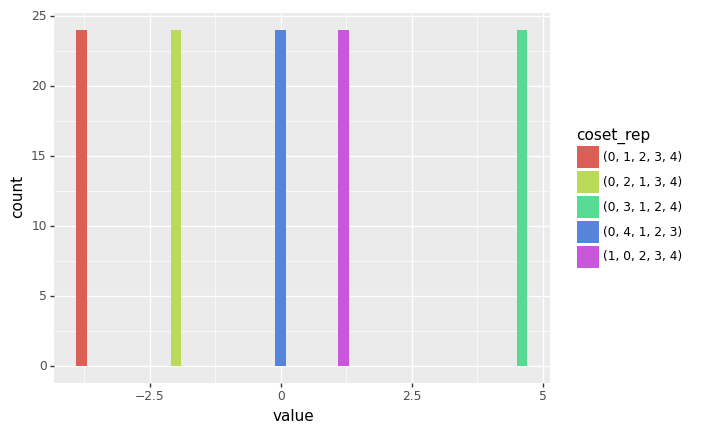

<ggplot: (690376200)>

In [19]:
df = (
    left_base_df
    .join(full_right_coset_df.filter(pl.col('subgroup') == 's4_1'), on='permutation', how='inner')
   
)

ggplot(df.filter(pl.col('variable') == 'dim0'), aes(x='value', fill='coset_rep')) + geom_histogram(binwidth=0.2)

In [31]:
df.filter(pl.col('variable') == 'dim0').groupby('coset_rep').agg(pl.col('value').var())

coset_rep,value
str,f32
"""(0, 3, 1, 2, 4…",4.8595e-7
"""(1, 0, 2, 3, 4…",3.7987e-7
"""(0, 4, 1, 2, 3…",5.2692e-7
"""(0, 2, 1, 3, 4…",4.5178e-7
"""(0, 1, 2, 3, 4…",1.0651e-7


In [19]:
(
    left_base_df
    .join(full_right_coset_df.filter(pl.col('subgroup') == 's4_0'), on='permutation', how='inner')
   
)

layer,permutation,variable,value,subgroup,coset_rep
str,str,str,f32,str,str
"""left_linear""","""(0, 4, 3, 2, 1…","""dim0""",-0.02683,"""s4_0""","""(0, 1, 2, 3, 4…"
"""left_linear""","""(1, 2, 4, 0, 3…","""dim0""",-1.923691,"""s4_0""","""(1, 0, 2, 3, 4…"
"""left_linear""","""(2, 3, 0, 1, 4…","""dim0""",4.553886,"""s4_0""","""(2, 0, 1, 3, 4…"
"""left_linear""","""(3, 0, 4, 2, 1…","""dim0""",1.211835,"""s4_0""","""(3, 0, 1, 2, 4…"
"""left_linear""","""(3, 1, 0, 2, 4…","""dim0""",-3.800956,"""s4_0""","""(3, 0, 1, 2, 4…"
"""left_linear""","""(3, 1, 2, 4, 0…","""dim0""",-3.801099,"""s4_0""","""(3, 0, 1, 2, 4…"
"""left_linear""","""(4, 2, 0, 1, 3…","""dim0""",-1.923987,"""s4_0""","""(4, 0, 1, 2, 3…"
"""left_linear""","""(0, 1, 2, 4, 3…","""dim0""",-3.800729,"""s4_0""","""(0, 1, 2, 3, 4…"
"""left_linear""","""(0, 2, 1, 3, 4…","""dim0""",-1.923277,"""s4_0""","""(0, 1, 2, 3, 4…"


In [32]:
#base_df.join(s4_right_coset_df.melt(id_vars='permutation'))
(
    left_base_df
    .join(full_right_coset_df, on='permutation', how='inner')
    .groupby(['layer', 'variable', 'subgroup', 'coset_rep'])
    .agg([
        pl.col('value').var().alias('coset_var'),
        pl.col('value').mean().alias('coset_mean')
    ])
    
    .groupby(['layer', 'variable', 'subgroup'], maintain_order=True)
    .agg([
        pl.col('coset_var').sum().alias('coset_cond_var'),
    ])
    .sort(['variable', 'coset_cond_var'])
    .groupby(['layer', 'variable'], maintain_order=True)
    .agg([
        pl.col('subgroup').first(),
        pl.col('coset_cond_var').first().alias('min_coset_var'),
        (pl.col('coset_cond_var').mean() - pl.col('coset_cond_var').first()).alias('sanity')
    ])
).sort('variable').filter(pl.col('subgroup') == 'a5')

layer,variable,subgroup,min_coset_var,sanity
str,str,str,f32,f32


In [230]:
#  (1,2,3), (1,2)(4,5) 
from itertools import product

three_cycles = [p.sigma for p in Permutation.full_group(5) if p.conjugacy_class == (3, 1, 1)]
double_transpo = [p.sigma for p in Permutation.full_group(5) if p.conjugacy_class == (2, 2, 1)]


twisted = set()
generators = []

for fc, t in product(three_cycles, double_transpo):
    sg = generate_subgroup([fc, t])
    if len(sg) == 6:
        sg = tuple(sorted(sg))
        if sg in twisted:
            continue
        else:
            generators.append((fc, t))
            twisted.add(sg)
            
    

generators

[((0, 1, 3, 4, 2), (1, 0, 2, 4, 3)),
 ((0, 2, 3, 1, 4), (4, 1, 3, 2, 0)),
 ((0, 2, 4, 3, 1), (3, 1, 4, 0, 2)),
 ((0, 3, 2, 4, 1), (2, 1, 0, 4, 3)),
 ((1, 2, 0, 3, 4), (0, 2, 1, 4, 3)),
 ((1, 3, 2, 0, 4), (0, 3, 4, 1, 2)),
 ((1, 4, 2, 3, 0), (0, 4, 3, 2, 1)),
 ((2, 1, 3, 0, 4), (0, 4, 3, 2, 1)),
 ((2, 1, 4, 3, 0), (0, 3, 4, 1, 2)),
 ((3, 1, 2, 4, 0), (0, 2, 1, 4, 3))]

In [231]:
[list(g) for g in generators]

[[(0, 1, 3, 4, 2), (1, 0, 2, 4, 3)],
 [(0, 2, 3, 1, 4), (4, 1, 3, 2, 0)],
 [(0, 2, 4, 3, 1), (3, 1, 4, 0, 2)],
 [(0, 3, 2, 4, 1), (2, 1, 0, 4, 3)],
 [(1, 2, 0, 3, 4), (0, 2, 1, 4, 3)],
 [(1, 3, 2, 0, 4), (0, 3, 4, 1, 2)],
 [(1, 4, 2, 3, 0), (0, 4, 3, 2, 1)],
 [(2, 1, 3, 0, 4), (0, 4, 3, 2, 1)],
 [(2, 1, 4, 3, 0), (0, 3, 4, 1, 2)],
 [(3, 1, 2, 4, 0), (0, 2, 1, 4, 3)]]

In [20]:
def coset_analysis(data, coset_df):
    base_df = (
        data
        .melt(id_vars=['layer', 'permutation', 'irrep'])
        .groupby(['layer', 'permutation', 'variable'])
        .agg(pl.col('value').sum())
    )
    summary_df = (
        base_df
        .groupby(['layer', 'variable'])
        .agg([
            pl.col('value').mean().alias('mean'),
            pl.col('value').min().alias('min'),
            pl.col('value').max().alias('max'),
            pl.col('value').var().alias('full_var'),
            (pl.col('value') ** 2).sum().alias('two_norm')
        ])
    )
    
    df = (
        base_df
        ##### Join against _all_ cosets, this is a many-to-1 join
        .join(coset_df, on='permutation', how='inner')
        .groupby(['layer', 'variable', 'subgroup', 'coset_rep'])
        .agg([
            # Get the average value and variance of the (per dim) activations over a single coset
            # Small variance --> activations highly concentrated on the coset
            pl.col('value').var().alias('coset_var'),
            pl.col('value').mean().alias('coset_mean')
        ])
        .sort(['variable', 'subgroup', 'coset_rep'])
        .groupby(['layer', 'variable', 'subgroup'], maintain_order=True)
        # Sum all the variances of the cosets for one subgroup
        .agg(pl.col('coset_var').sum().alias('coset_cond_var'))
        # Sort ascending by coset variance
        .sort(['variable', 'coset_cond_var'])
        .groupby(['layer', 'variable'], maintain_order=True)
        .agg([
            # 
            pl.col('subgroup').first(),
            pl.col('coset_cond_var').first().alias('min_coset_var'),
            (pl.col('coset_cond_var').mean() - pl.col('coset_cond_var').first()).alias('sanity')
        ])
        .join(summary_df, on=['layer', 'variable'])
        .sort('subgroup')
    )
    return df
        
        
        

def _make_one_coset_df(sg_def, n, name):
        all_subgroups = [generate_subgroup(gen) for gen in sg_def['generators']]
        right_coset_df = make_right_full_coset_df(all_subgroups, n, name)
        left_coset_df = make_left_full_coset_df(all_subgroups, n, name)
        return left_coset_df, right_coset_df
        
        

def make_full_coset_df():
        frob_groups = {
            "order": 20,
            "copies": 6,
            "generators": [
                [(0, 2, 3, 4, 1), (1, 2, 4, 0, 3)],
                [(0, 2, 3, 4, 1), (1, 4, 3, 0, 2)],
                [(0, 2, 4, 1, 3), (1, 2, 3, 4, 0)],
                [(0, 2, 4, 1, 3), (1, 3, 4, 2, 0)],
                [(0, 3, 4, 2, 1), (1, 3, 0, 4, 2)],
                [(0, 3, 4, 2, 1), (1, 4, 0, 2, 3)]
            ]
        }
        d8_subgroups = {
            "order": 8,
            "copies": 15,
            "generators": [
                [(0, 2, 3, 4, 1), (0, 1, 4, 3, 2)],
                [(0, 2, 4, 1, 3), (0, 1, 3, 2, 4)],
                [(0, 3, 4, 2, 1), (0, 1, 2, 4, 3)],
                [(1, 2, 3, 0, 4), (0, 3, 2, 1, 4)],
                [(1, 2, 4, 3, 0), (0, 4, 2, 3, 1)],
                [(1, 3, 0, 2, 4), (0, 2, 1, 3, 4)],
                [(1, 3, 2, 4, 0), (0, 4, 2, 3, 1)],
                [(1, 4, 0, 3, 2), (0, 2, 1, 3, 4)],
                [(1, 4, 2, 0, 3), (0, 3, 2, 1, 4)],
                [(2, 1, 3, 4, 0), (0, 1, 4, 3, 2)],
                [(2, 1, 4, 0, 3), (0, 1, 3, 2, 4)],
                [(2, 3, 1, 0, 4), (0, 1, 3, 2, 4)],
                [(2, 4, 1, 3, 0), (0, 1, 4, 3, 2)],
                [(3, 1, 4, 2, 0), (0, 1, 2, 4, 3)],
                [(3, 4, 2, 1, 0), (0, 1, 2, 4, 3)]
            ]
        }
        d10_subgroups = {
            "order": 10,
            "copies": 6,
            "generators": [
                [(1, 2, 3, 4, 0), (0, 4, 3, 2, 1)],
                [(1, 2, 4, 0, 3), (0, 3, 4, 1, 2)],
                [(1, 3, 0, 4, 2), (0, 2, 1, 4, 3)],
                [(1, 3, 4, 2, 0), (0, 4, 3, 2, 1)],
                [(1, 4, 0, 2, 3), (0, 2, 1, 4, 3)],
                [(1, 4, 3, 0, 2), (0, 3, 4, 1, 2)]
            ]
        }
        s3xs2_subgroups = {
            "order": 12,
            "copies": 10,
            "generators": [
                [(0, 1, 3, 4, 2), (0, 1, 3, 2, 4), (1, 0, 2, 3, 4)], #1
                [(0, 3, 2, 4, 1), (0, 1, 2, 4, 3), (2, 1, 0, 3, 4)], #2
                [(0, 2, 4, 3, 1), (0, 2, 1, 3, 4), (3, 1, 2, 0, 4)], #3
                [(0, 2, 3, 1, 4), (0, 2, 1, 3, 4), (4, 1, 2, 3, 0)], #4
                [(3, 1, 2, 4, 0), (3, 1, 2, 0, 4), (0, 2, 1, 3, 4)], #5
                [(2, 1, 4, 3, 0), (2, 1, 0, 3, 4), (0, 3, 2, 1, 4)], #6
                [(2, 1, 3, 0, 4), (2, 1, 0, 3, 4), (0, 4, 2, 3, 1)], #7
                [(1, 4, 2, 3, 0), (1, 0, 2, 3, 4), (0, 1, 3, 2, 4)], #8
                [(1, 3, 2, 0, 4), (1, 0, 2, 3, 4), (0, 1, 4, 3, 2)], #9
                [(1, 2, 0, 3, 4), (1, 0, 2, 3, 4), (0, 1, 2, 4, 3)], #10
            ]

        }
        s4_subgroups = {
            "order": 12,
            "copies": 5,
            "generators": [
                [(0, 2, 3, 4, 1), (0, 2, 1, 3, 4)], #1 fix 0
                [(2, 1, 3, 4, 0), (2, 1, 0, 3, 4)], #2 fix 1
                [(1, 3, 2, 4, 0), (1, 0, 2, 3, 4)], #3 fix 2
                [(1, 2, 4, 3, 0), (1, 0, 2, 3, 4)], #4 fix 3
                [(1, 2, 3, 0, 4), (1, 0, 2, 3, 4)], #5 fix 4
            ]
        }

        s3_subgroups = {
            "order": 6,
            "copies": 10,
            "generators": [
                [(0, 1, 3, 4, 2), (0, 1, 3, 2, 4)], #1  fix 0 1
                [(0, 3, 2, 4, 1), (0, 1, 2, 4, 3)], #2  fix 0 2
                [(0, 2, 4, 3, 1), (0, 2, 1, 3, 4)], #3  fix 0 3
                [(0, 2, 3, 1, 4), (0, 2, 1, 3, 4)], #4  fix 0 4
                [(3, 1, 2, 4, 0), (3, 1, 2, 0, 4)], #5  fix 1 2
                [(2, 1, 4, 3, 0), (2, 1, 0, 3, 4)], #6  fix 1 3
                [(2, 1, 3, 0, 4), (2, 1, 0, 3, 4)], #7  fix 1 4
                [(1, 4, 2, 3, 0), (1, 0, 2, 3, 4)], #8  fix 2 3
                [(1, 3, 2, 0, 4), (1, 0, 2, 3, 4)], #9  fix 2 4
                [(1, 2, 0, 3, 4), (1, 0, 2, 3, 4)], #10 fix 3 4
            ]
        }
        
        twisted_s3_subgroups = {
            "order": 6,
            "copies": 10,
            "generators": [
                [(0, 1, 3, 4, 2), (1, 0, 2, 4, 3)],
                [(0, 2, 3, 1, 4), (4, 1, 3, 2, 0)],
                [(0, 2, 4, 3, 1), (3, 1, 4, 0, 2)],
                [(0, 3, 2, 4, 1), (2, 1, 0, 4, 3)],
                [(1, 2, 0, 3, 4), (0, 2, 1, 4, 3)],
                [(1, 3, 2, 0, 4), (0, 3, 4, 1, 2)],
                [(1, 4, 2, 3, 0), (0, 4, 3, 2, 1)],
                [(2, 1, 3, 0, 4), (0, 4, 3, 2, 1)],
                [(2, 1, 4, 3, 0), (0, 3, 4, 1, 2)],
                [(3, 1, 2, 4, 0), (0, 2, 1, 4, 3)]
            ]
        }
        a4_subgroups = {
            "order": 12,
            "copies": 5,
            "generators": [
                [(0, 2, 1, 4, 3), (0, 3, 1, 2, 4)], # 1 fix 0
                [(2, 1, 0, 4, 3), (0, 1, 4, 2, 3)], # 2 fix 1
                [(1, 0, 2, 4, 3), (3, 0, 2, 1, 4)], # 3 fix 2
                [(1, 0, 4, 3, 2), (2, 0, 1, 3, 4)], # 4 fix 3
                [(1, 0, 3, 2, 4), (2, 0, 1, 3, 4)], # 5 fix 4

            ]
        }
        z5_subgroups = {
            "order": 5,
            "copies": 6,
            "generators": [
                [(1, 2, 4, 0, 3)],
                [(1, 4, 3, 0, 2)],
                [(1, 2, 3, 4, 0)],
                [(1, 3, 4, 2, 0)],
                [(1, 3, 0, 4, 2)],
                [(1, 4, 0, 2, 3)]
            ]
        }
        z6_subgroups = {
            "order": 6,
            "copies": 10,
            "generators": [
                [(0, 1, 3, 4, 2), (1, 0, 2, 3, 4)], #1  fix 0 1
                [(0, 3, 2, 4, 1), (2, 1, 0, 3, 4)], #2  fix 0 2
                [(0, 2, 4, 3, 1), (3, 1, 2, 0, 4)], #3  fix 0 3
                [(0, 2, 3, 1, 4), (4, 1, 2, 3, 0)], #4  fix 0 4
                [(3, 1, 2, 4, 0), (0, 2, 1, 3, 4)], #5  fix 1 2
                [(2, 1, 4, 3, 0), (0, 3, 2, 1, 4)], #6  fix 1 3
                [(2, 1, 3, 0, 4), (0, 4, 2, 3, 1)], #7  fix 1 4
                [(1, 4, 2, 3, 0), (0, 1, 3, 2, 4)], #8  fix 2 3
                [(1, 3, 2, 0, 4), (0, 1, 4, 3, 2)], #9  fix 2 4
                [(1, 2, 0, 3, 4), (0, 1, 2, 4, 3)], #10 fix 3 4
            ]
        }
        a5_subgroups = {
            "order": 60,
            "copies": 1,
            "generators": [[(4, 0, 1, 2, 3), (2, 0, 1, 3, 4)]]
        }
        
        left_a5_df, right_a5_df = _make_one_coset_df(a5_subgroups, 5, 'a5')
        left_z6_df, right_z6_df = _make_one_coset_df(z6_subgroups, 5, 'z6')
        left_z5_df, right_z5_df = _make_one_coset_df(z5_subgroups, 5, 'z5')
        left_a4_df, right_a4_df = _make_one_coset_df(a4_subgroups, 5, 'a4')
        left_s4_df, right_s4_df = _make_one_coset_df(s4_subgroups, 5, 's4')
        left_s3_df, right_s3_df = _make_one_coset_df(s3_subgroups, 5, 's3')
        left_frob_df, right_frob_df = _make_one_coset_df(frob_groups, 5, 'frob20')
        left_s3xs2_df, right_s3xs2_df = _make_one_coset_df(s3xs2_subgroups, 5, 's3xs2')
        left_d8_df, right_d8_df = _make_one_coset_df(s3xs2_subgroups, 5, 'd8')
        left_d10_df, right_d10_df = _make_one_coset_df(s3xs2_subgroups, 5, 'd10')
        left_twisteds3_df, right_twisteds3_df = _make_one_coset_df(twisted_s3_subgroups, 5, 'twisteds3')
        
        
        left_df = pl.concat([
            left_a5_df, left_z6_df, left_z5_df, left_a4_df, left_s4_df,
            left_s3_df, left_frob_df, left_s3xs2_df, left_d8_df, left_d10_df,
            left_twisteds3_df
        ])
        right_df = pl.concat([
            right_a5_df, right_z6_df, right_z5_df, right_a4_df, right_s4_df, 
            right_s3_df, right_frob_df, right_s3xs2_df, right_d8_df, right_d10_df,
            right_twisteds3_df
        ])
        
        return left_df, right_df
                


def transpose_power_df(data):
    irreps = data['irrep'].to_list()
    return (
        data
        .select(pl.exclude('irrep'))
        .transpose(
            include_header=True,
            header_name='variable', 
            column_names=irreps)
    )


def fp_sort_key(fp):
    last_part = fp.parts[-1].strip('.pth')
    if last_part == 'full_run':
        return 2 ** 10000
    else:
        return int(last_part)
    
    
def _analysis(model_run, perms, full_left_coset_df, full_right_coset_df):
    lperms, rperms, targets = perms
    
    model = SnMLP.from_config(model_run['config'])
    model.load_state_dict(model_run['model'])

    logits, cache = model.run_with_cache(lperms, rperms)
    
    original_loss = loss_fn(logits, targets).mean()
    
    linear_acts = cache['hook_linear']
    S5 = Symmetric(5)
    
    config = model_run['config']
    embed_dim = config['embed_dim']
    W = model.linear.weight

    lpower_df, llinear_ft = calc_power_contributions(model.lembed.weight @ W[:, :embed_dim].T, 5)
    rpower_df, rlinear_ft = calc_power_contributions(model.rembed.weight @ W[:, embed_dim:].T, 5)
    
        
    lpower_df = transpose_power_df(lpower_df)
    rpower_df = transpose_power_df(rpower_df)
    
    num_rows = lpower_df.shape[0]
    
    lpower_df.insert_at_idx(0, pl.Series('layer', ['left_linear'] * num_rows))
    rpower_df.insert_at_idx(0, pl.Series('layer', ['right_linear'] * num_rows))
    power_df = pl.concat([lpower_df, rpower_df], how='vertical')
    
    llinear_decomp = sn_fourier_basis(llinear_ft, S5)
    rlinear_decomp = sn_fourier_basis(rlinear_ft, S5)
    
    llinear_df = fourier_basis_to_df(llinear_decomp, 5, 'left_linear')
    rlinear_df = fourier_basis_to_df(rlinear_decomp, 5, 'right_linear')
    
    full_left_coset_df, full_right_coset_df = make_full_coset_df()

    left_perm_coset_df = coset_analysis(llinear_df, full_right_coset_df)
    right_perm_coset_df = coset_analysis(rlinear_df, full_left_coset_df)

    left_perm_coset_df = (
        left_perm_coset_df
        .select(pl.exclude(['sanity']))
        .with_columns(
            coset_var_ratio = (pl.col('min_coset_var') / pl.col('full_var')),
            subgroup_class = pl.col('subgroup').str.split(by='_').list.get(0)
        )
    )
        

    right_perm_coset_df = (
        right_perm_coset_df
        .select(pl.exclude(['sanity']))
        .with_columns(
            coset_var_ratio = (pl.col('min_coset_var') / pl.col('full_var')),
            subgroup_class = pl.col('subgroup').str.split(by='_').list.get(0)
        )
    )
    
    left_right_df = pl.concat([left_perm_coset_df, right_perm_coset_df])
    
    left_perm_coset_df = left_perm_coset_df.rename({
        'subgroup': 'left_subgroup',
        'mean': 'left_mean_preactivation',
        'max': 'left_min_preactivation',
        'full_var': 'left_full_var',
        'two_norm': 'left_two_norm',
        'min_coset_var': 'left_min_coset_var',
        'coset_var_ratio': 'left_coset_var_ratio',
        'subgroup_class': 'left_subgroup_class'
        
    })
    
    
    right_perm_coset_df = right_perm_coset_df.rename({
        'subgroup': 'right_subgroup',
        'mean': 'right_mean_preactivation',
        'max': 'right_min_preactivation',
        'full_var': 'right_full_var',
        'two_norm': 'right_two_norm',
        'min_coset_var': 'right_min_coset_var',
        'coset_var_ratio': 'right_coset_var_ratio',
        'subgroup_class': 'right_subgroup_class'
    })
    
    linear_coset_df = (
        left_perm_coset_df
        .join(right_perm_coset_df, on='variable', how='inner')
        .with_columns([
            ('(' + pl.col('left_subgroup') + ', ' + pl.col('right_subgroup') + ')').alias('subgroup_pair'),
            ((pl.col('left_min_coset_var') + pl.col('right_min_coset_var'))/ 2).alias('coset_var'),
            ((pl.col('left_coset_var_ratio') + pl.col('right_coset_var_ratio'))/ 2).alias('coset_var_ratio'),
            ((pl.col('left_two_norm') + pl.col('right_two_norm'))/ 2).alias('two_norm'),
            (
                pl.when(pl.col('left_subgroup_class') == pl.col('right_subgroup_class'))
                .then(pl.col('left_subgroup_class'))
                .otherwise(pl.lit('mixed'))
            ).alias('subgroup_class')
        ]).sort('subgroup_pair')
    )
    return linear_coset_df, left_right_df
    

def cosets_over_time(model_seed):
    ckpt_dir = Path('/Users/dashiell/workspace/sn-grok/s5_40_small')
    run_name = f's5_40_{model_seed}'

    #whole_config = Config().from_disk('configs/s5_lr_5.toml')
    run_dir = ckpt_dir / run_name
    full_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
    run_data = pl.read_parquet(run_dir / f'data.parquet')
    lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
    rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
    targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()
    
    full_left_coset_df, full_right_coset_df = make_full_coset_df()
    
    checkpoint_epochs = full_run['checkpoint_epochs'] + [249999]
    checkpoint_paths = sorted([fp for fp in run_dir.glob('*.pth')], key=fp_sort_key)
    
    merged_data = []
    lr_data = []
    
    for epoch, ckpt_fp in zip(checkpoint_epochs, checkpoint_paths):
        ckpt = torch.load(ckpt_fp, map_location=torch.device('cpu'))
        both_df, left_right_df = _analysis(ckpt, (lperms, rperms, targets), full_left_coset_df, full_right_coset_df)
        both_df.insert_at_idx(0, pl.Series('epoch', [epoch] * both_df.shape[0]))
        left_right_df.insert_at_idx(0, pl.Series('epoch', [epoch] * left_right_df.shape[0]))
        merged_data.append(both_df)
        lr_data.append(left_right_df)
                
    return pl.concat(merged_data, how='vertical'), pl.concat(lr_data, how='vertical')
    
    

In [66]:
def get_linear_layer_decomp(model_seed):
    ckpt_dir = Path('/Users/dashiell/workspace/sn-grok/s5_40_small')
    run_name = f's5_40_{model_seed}'

    #whole_config = Config().from_disk('configs/s5_lr_5.toml')
    run_dir = ckpt_dir / run_name
    full_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
    run_data = pl.read_parquet(run_dir / f'data.parquet')
    lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
    rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
    targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()
    
    #full_left_coset_df, full_right_coset_df = make_full_coset_df()
    
    checkpoint_epochs = full_run['checkpoint_epochs'] + [249999]
    checkpoint_paths = sorted([fp for fp in run_dir.glob('*.pth')], key=fp_sort_key)
    
    model = SnMLP.from_config(full_run['config'])
    model.load_state_dict(full_run['model'])

    logits, cache = model.run_with_cache(lperms, rperms)
    loss = loss_fn(logits, targets)

    linear_acts = cache['hook_linear']
    df = pl.concat(
        [run_data, pl.DataFrame(linear_acts.detach().numpy(), schema=[f'dim{i}' for i in range(linear_acts.shape[1])])],
        how='horizontal'
    )
    return df.select(pl.exclude(['index_left', 'index_right', 'index_target', 'in_train']))
    
    

In [21]:
merged_df, lr_df = cosets_over_time(5)

In [122]:
(
    merged_df
    .filter((pl.col('left_coset_var_ratio') < 1.0) & (pl.col('right_coset_var_ratio') < 1.0) & (pl.col('epoch') == 249999))
    #.filter(pl.col('subgroup_pair') == "(a5_0, a5_0)")
    .filter(pl.col('left_subgroup') == "s4_0")
    .filter(pl.col('seed') == 5)
)

seed,epoch,layer,variable,left_subgroup,left_min_coset_var,left_mean_preactivation,min,left_min_preactivation,left_full_var,left_two_norm,left_coset_var_ratio,left_subgroup_class,layer_right,right_subgroup,right_min_coset_var,right_mean_preactivation,min_right,right_min_preactivation,right_full_var,right_two_norm,right_coset_var_ratio,right_subgroup_class,subgroup_pair,coset_var,coset_var_ratio,two_norm,subgroup_class
i64,i64,str,str,str,f32,f32,f32,f32,f32,f32,f32,str,str,str,f32,f32,f32,f32,f32,f32,f32,str,str,f32,f32,f32,str
5,249999,"""left_linear""","""dim23""","""s4_0""",4.9693e-7,-0.00004,-3.483833,3.935959,7.771808,924.845154,6.3940e-8,"""s4""","""right_linear""","""s4_0""",3.0115e-7,0.000031,-3.935493,3.483232,7.770484,924.687683,3.8755e-8,"""s4""","""(s4_0, s4_0)""",3.9904e-7,5.1348e-8,924.766418,"""s4"""
5,249999,"""left_linear""","""dim51""","""s4_0""",4.4206e-7,-0.000017,-3.762193,4.269928,8.532125,1015.322876,5.1811e-8,"""s4""","""right_linear""","""s4_0""",2.8876e-7,-0.000021,-4.269964,3.762142,8.532679,1015.388916,3.3841e-8,"""s4""","""(s4_0, s4_0)""",3.6541e-7,4.2826e-8,1015.355896,"""s4"""
5,249999,"""left_linear""","""dim126""","""s4_0""",2.8569e-7,0.000043,-3.714198,3.175883,6.950356,827.092529,4.1104e-8,"""s4""","""right_linear""","""s4_0""",2.7429e-7,-0.000006,-3.175392,3.713664,6.949374,826.975708,3.9469e-8,"""s4""","""(s4_0, s4_0)""",2.7999e-7,4.0287e-8,827.034119,"""s4"""
5,249999,"""left_linear""","""dim42""","""s4_0""",4.5527e-7,0.000031,-3.774169,3.319347,6.658996,792.42041,6.8369e-8,"""s4""","""right_linear""","""s4_0""",3.0832e-7,0.000016,-3.319412,3.77415,6.659159,792.439941,4.6300e-8,"""s4""","""(s4_0, s4_0)""",3.8179e-7,5.7334e-8,792.430176,"""s4"""
5,249999,"""left_linear""","""dim53""","""s4_0""",2.7961e-7,0.000022,-3.940316,3.443782,7.231748,860.577881,3.8664e-8,"""s4""","""right_linear""","""s4_1""",3.9681e-7,0.000032,-3.443937,3.940901,7.232544,860.672668,5.4865e-8,"""s4""","""(s4_0, s4_1)""",3.3821e-7,4.6764e-8,860.625244,"""s4"""
5,249999,"""left_linear""","""dim13""","""s4_0""",1.7373e-7,0.000044,-3.012617,2.755074,4.555961,542.159424,3.8132e-8,"""s4""","""right_linear""","""s4_1""",1.6470e-7,-0.000034,-2.75495,3.012457,4.555613,542.117859,3.6153e-8,"""s4""","""(s4_0, s4_1)""",1.6921e-7,3.7143e-8,542.138672,"""s4"""
5,249999,"""left_linear""","""dim82""","""s4_0""",3.9342e-7,-0.000078,-4.461767,4.243289,9.600777,1142.492554,4.0978e-8,"""s4""","""right_linear""","""s4_1""",8.1798e-7,0.000146,-4.242594,4.462132,9.599972,1142.396606,8.5207e-8,"""s4""","""(s4_0, s4_1)""",6.0570e-7,6.3092e-8,1142.44458,"""s4"""
5,249999,"""left_linear""","""dim37""","""s4_0""",5.0989e-7,-0.000003,-3.831548,4.068759,8.026391,955.140686,6.3526e-8,"""s4""","""right_linear""","""s4_1""",3.2758e-7,0.000011,-4.068617,3.831533,8.026359,955.136475,4.0813e-8,"""s4""","""(s4_0, s4_1)""",4.1873e-7,5.2170e-8,955.13855,"""s4"""
5,249999,"""left_linear""","""dim32""","""s4_0""",3.0667e-7,-0.000025,-3.386328,3.47276,6.084614,724.069214,5.0400e-8,"""s4""","""right_linear""","""s4_2""",3.2934e-7,-0.000017,-3.472518,3.386218,6.084774,724.088074,5.4126e-8,"""s4""","""(s4_0, s4_2)""",3.1800e-7,5.2263e-8,724.078613,"""s4"""


In [117]:
llinear_df, rlinear_df, unembed_df, power_df = fourier_stats(5)
left_base_df = llinear_df.melt(id_vars=['layer', 'permutation', 'irrep']).groupby(['layer', 'permutation', 'variable']).agg(pl.col('value').sum())
right_base_df = rlinear_df.melt(id_vars=['layer', 'permutation', 'irrep']).groupby(['layer', 'permutation', 'variable']).agg(pl.col('value').sum())
full_left_coset_df, full_right_coset_df = make_full_coset_df()

In [118]:
def if_then(pred, x0, x1):
    return pl.when(pred).then(pl.lit(x0)).otherwise(pl.lit(x1))

In [119]:
linear_df = get_linear_layer_decomp(5)

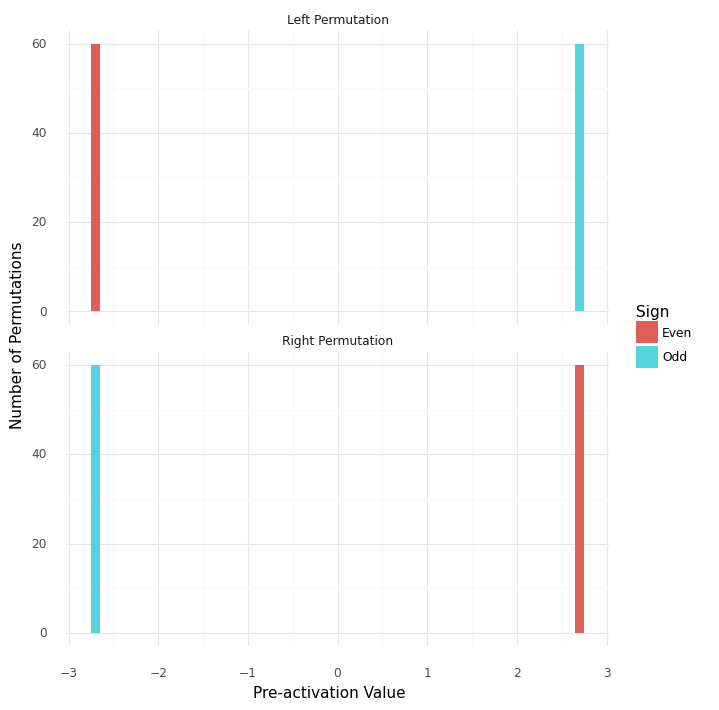

<ggplot: (686607039)>

In [120]:
from plotnine import labs, theme_minimal, theme_linedraw, geom_dotplot
dfl = (
    left_base_df
    .filter(pl.col('variable') == 'dim16')
    .join(full_left_coset_df.filter(pl.col('subgroup') == 'a5_0'), on='permutation')
    .with_columns(if_then((pl.col('coset_rep') == "(0, 1, 2, 3, 4)"), "Even", "Odd").alias('sign'))
)
dfr = (
    right_base_df
    .filter(pl.col('variable') == 'dim16')
    .join(full_left_coset_df.filter(pl.col('subgroup') == 'a5_0'), on='permutation')
    .with_columns(
        if_then((pl.col('coset_rep') == "(0, 1, 2, 3, 4)"), "Even", "Odd").alias('sign'))
)
dfl.insert_at_idx(0, pl.Series('side', ['Left Permutation'] * 120))
dfr.insert_at_idx(0, pl.Series('side', ['Right Permutation'] * 120))

df = pl.concat([dfl, dfr], how='vertical')


fig = (
    ggplot(df, aes(x='value', fill='sign')) 
    + geom_histogram(binwidth=0.1) 
    + facet_wrap('~side', nrow=2)
    + labs(y = "Number of Permutations", x = "Pre-activation Value", fill="Sign")
    + theme_minimal()
    + theme(figure_size=(7,8))
)
fig


In [46]:
fig.save('s5_40_seed5_dim16_sign_plot.png')


/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 7 x 8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: s5_40_seed5_dim16_sign_plot.png


In [78]:
dflin = (
    linear_df
    .select(['permutation_target', 'dim16'])
    .join(full_left_coset_df.filter(pl.col('subgroup') == 'a5_0'), left_on='permutation_target', right_on='permutation')
    .with_columns(
        if_then((pl.col('coset_rep') == "(0, 1, 2, 3, 4)"), "Even", "Odd").alias('sign'),
        pl.Series('layer', ['Left + Right Permutations']* 14400)
    )
)

fig = (
    ggplot(dflin, aes(x='dim16', fill = 'sign')) 
    + geom_histogram(binwidth=0.2)
    + facet_wrap('~layer')
    + labs(y = "Number of Permutations", x = "Full Pre-activation Value", fill="Sign")
    + theme_minimal()
)

In [79]:
fig.save('left_and_right_s5_40_seed5_dim16_sign_plot.png')

/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: left_and_right_s5_40_seed5_dim16_sign_plot.png


In [83]:
fig = (
    ggplot(dflin.with_columns(pl.col('dim16').clip_min(0)), aes(x='dim16', fill = 'sign')) 
    + geom_histogram(binwidth=0.2)
    + facet_wrap('~layer')
    + labs(y = "Number of Permutation Pairs", x = "Full Activation Value (post-ReLU)", fill="Sign")
    + theme_minimal()
)
fig
fig.save('relu_s5_40_seed5_dim16_sign_plot.png')

/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: relu_s5_40_seed5_dim16_sign_plot.png


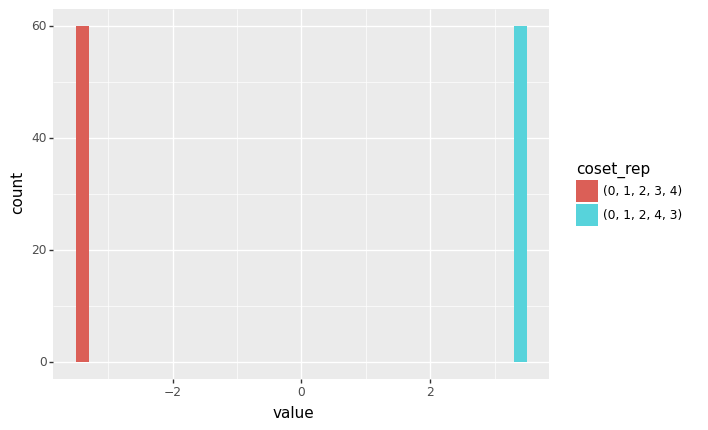

<ggplot: (681121552)>

In [56]:
df = right_base_df.filter(pl.col('variable') == 'dim92').join(full_left_coset_df.filter(pl.col('subgroup') == 'a5_0'), on='permutation')
ggplot(df, aes(x='value', fill='coset_rep')) + geom_histogram(binwidth=0.2)

In [121]:
left_base_df.filter(pl.col('variable') == 'dim100')

layer,permutation,variable,value
str,str,str,f32
"""left_linear""","""(0, 3, 1, 2, 4…","""dim100""",-0.000862
"""left_linear""","""(0, 4, 3, 2, 1…","""dim100""",-0.000862
"""left_linear""","""(1, 0, 3, 2, 4…","""dim100""",-0.000186
"""left_linear""","""(1, 0, 4, 3, 2…","""dim100""",-0.000186
"""left_linear""","""(2, 0, 3, 4, 1…","""dim100""",-0.000354
"""left_linear""","""(2, 1, 3, 0, 4…","""dim100""",-0.000354
"""left_linear""","""(3, 4, 1, 2, 0…","""dim100""",0.000912
"""left_linear""","""(4, 0, 3, 1, 2…","""dim100""",0.00049
"""left_linear""","""(4, 3, 0, 2, 1…","""dim100""",0.000491


/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 7 x 8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: s5_40_seed5_dim23_s4_plot.png


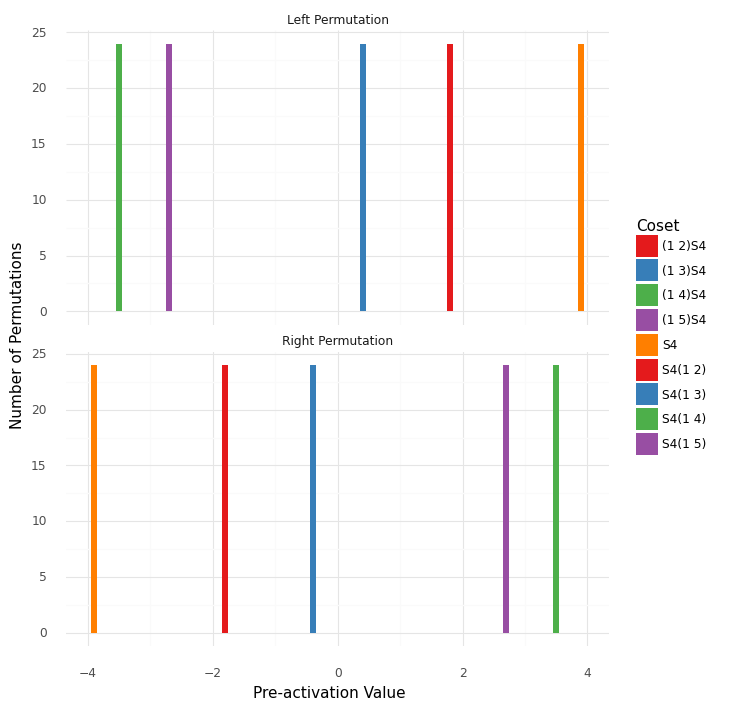

<ggplot: (687945029)>

In [164]:
from plotnine import labs, theme_minimal, theme_linedraw, geom_dotplot, scale_color_manual, scale_fill_manual
from mizani.palettes import brewer_pal


left_coset_rename = {
    '(0, 1, 2, 3, 4)': 'S4',
    '(1, 0, 2, 3, 4)': '(1 2)S4',
    '(1, 2, 0, 3, 4)': '(1 3)S4',
    '(1, 2, 3, 0, 4)': '(1 4)S4',
    '(1, 2, 3, 4, 0)': '(1 5)S4',

}

right_coset_rename = {
    '(0, 1, 2, 3, 4)': 'S4',
    '(1, 0, 2, 3, 4)': 'S4(1 2)',
    '(2, 0, 1, 3, 4)': 'S4(1 3)',
    '(3, 0, 1, 2, 4)': 'S4(1 4)',
    '(4, 0, 1, 2, 3)': 'S4(1 5)'

}


dfl = (
    left_base_df
    .filter(pl.col('variable') == 'dim23')
    .join(full_right_coset_df.filter(pl.col('subgroup') == 's4_0'), on='permutation')
    .with_columns(pl.col('coset_rep').map_dict(right_coset_rename))
)
dfr = (
    right_base_df
    .filter(pl.col('variable') == 'dim23')
    .join(full_left_coset_df.filter(pl.col('subgroup') == 's4_0'), on='permutation')
    .with_columns(pl.col('coset_rep').map_dict(left_coset_rename))
    
)
dfl.insert_at_idx(0, pl.Series('side', ['Left Permutation'] * 120))
dfr.insert_at_idx(0, pl.Series('side', ['Right Permutation'] * 120))

df = pl.concat([dfl, dfr], how='vertical')

palette = brewer_pal('qual', 6)(5)

colors = palette + palette[:-1]


fig = (
    ggplot(df, aes(x='value', fill='coset_rep')) 
    + geom_histogram(binwidth=0.1) 
    + facet_wrap('~side', nrow=2)
    + labs(y = "Number of Permutations", x = "Pre-activation Value", fill="Coset")
    + theme_minimal()
    + theme(figure_size=(7,8))
    + scale_fill_manual(values = colors)
)

fig.save('s5_40_seed5_dim23_s4_plot.png')
fig

/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: s5_40_seed5_dim23_s4_full_plot.png


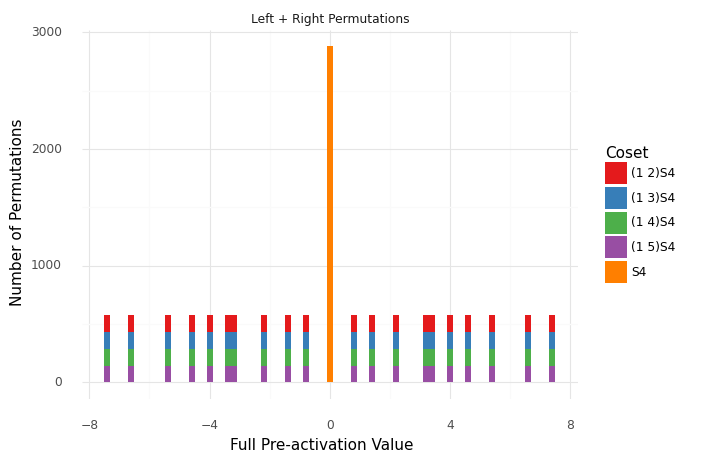

<ggplot: (688294919)>

In [165]:
from plotnine import scale_fill_brewer

dflin = (
    linear_df
    .select(['permutation_target', 'dim23'])
    .join(full_left_coset_df.filter(pl.col('subgroup') == 's4_0'), left_on='permutation_target', right_on='permutation')
    .with_columns(
        #if_then((pl.col('coset_rep') == "(0, 1, 2, 3, 4)"), "Even", "Odd").alias('sign'),
        pl.Series('layer', ['Left + Right Permutations']* 14400),
        pl.col('coset_rep').map_dict(left_coset_rename)
    )
)

fig = (
    ggplot(dflin, aes(x='dim23', fill = 'coset_rep')) 
    + geom_histogram(binwidth=0.2)
    + facet_wrap('~layer')
    + labs(y = "Number of Permutations", x = "Full Pre-activation Value", fill="Coset")
    + theme_minimal()
    + scale_fill_brewer(type='qual', palette=6)
)
fig.save('s5_40_seed5_dim23_s4_full_plot.png')
fig

/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: s5_40_seed5_dim23_s4_full_relu_plot.png


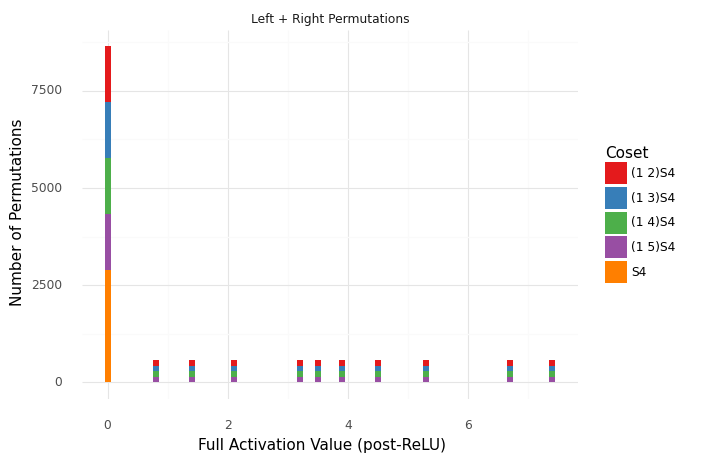

<ggplot: (671250123)>

In [166]:
fig = (
    ggplot(dflin.with_columns(pl.col('dim23').clip_min(0)), aes(x='dim23', fill = 'coset_rep')) 
    + geom_histogram(binwidth=0.1)
    + facet_wrap('~layer')
    + labs(y = "Number of Permutations", x = "Full Activation Value (post-ReLU)", fill="Coset")
    + theme_minimal()
    +  scale_fill_brewer(type='qual', palette=6)
)
fig.save('s5_40_seed5_dim23_s4_full_relu_plot.png')
fig

In [169]:
x = torch.randn((100, 100, 100, 100))
torch.fft.fftn(x).shape

torch.Size([100, 100, 100, 100])

In [143]:
from mizani.palettes import brewer_pal

In [147]:
brewer_pal()()

['#F7FBFF',
 '#DEEBF7',
 '#C6DBEF',
 '#9ECAE1',
 '#6BAED6',
 '#4292C6',
 '#2171B5',
 '#08519C',
 '#08306B']

In [260]:
from tqdm.notebook import tqdm

merged_data = []
lr_data = []

for i in tqdm(range(128)):
    merged_df, lr_df = cosets_over_time(i)
    merged_data.append(merged_df)
    lr_data.append(lr_df)
    
merged_df = pl.concat(merged_data)
lr_df = pl.concat(lr_data)

  0%|          | 0/128 [00:00<?, ?it/s]

In [285]:
merged_w_seed = [df.insert_at_idx(0, pl.Series('seed', [i] * df.shape[0])) for i, df in enumerate(merged_data)]
lr_w_seed = [df.insert_at_idx(0, pl.Series('seed', [i] * df.shape[0])) for i, df in enumerate(lr_data)]

In [286]:
merged_df = pl.concat(merged_w_seed)
lr_df = pl.concat(lr_w_seed)

In [84]:
#merged_df.write_parquet('s5_small_coset_stats.parquet')
#lr_df.write_parquet('s5_small_left_right_cosets.parquet')
merged_df = pl.read_parquet('s5_small_coset_stats.parquet')
lr_df = pl.read_parquet('s5_small_left_right_cosets.parquet')

In [104]:
merged_df.head()

seed,epoch,layer,variable,left_subgroup,left_min_coset_var,left_mean_preactivation,min,left_min_preactivation,left_full_var,left_two_norm,left_coset_var_ratio,left_subgroup_class,layer_right,right_subgroup,right_min_coset_var,right_mean_preactivation,min_right,right_min_preactivation,right_full_var,right_two_norm,right_coset_var_ratio,right_subgroup_class,subgroup_pair,coset_var,coset_var_ratio,two_norm,subgroup_class
i64,i64,str,str,str,f32,f32,f32,f32,f32,f32,f32,str,str,str,f32,f32,f32,f32,f32,f32,f32,str,str,f32,f32,f32,str
0,0,"""left_linear""","""dim5""","""a5_0""",0.325513,0.01931,-0.91423,1.275069,0.161517,19.265306,2.015344,"""a5""","""right_linear""","""a5_0""",0.363176,-0.04661,-1.078822,0.967914,0.181016,21.801584,2.006324,"""a5""","""(a5_0, a5_0)""",0.344345,2.010834,20.533445,"""a5"""
0,0,"""left_linear""","""dim14""","""a5_0""",0.356455,-0.029171,-0.981152,0.830798,0.176811,21.142574,2.016027,"""a5""","""right_linear""","""a5_0""",0.274251,-0.001815,-0.779906,0.939263,0.136014,16.186052,2.016345,"""a5""","""(a5_0, a5_0)""",0.315353,2.016186,18.664314,"""a5"""
0,0,"""left_linear""","""dim24""","""a5_0""",0.304858,-0.066634,-0.886384,0.844595,0.151148,18.519444,2.016949,"""a5""","""right_linear""","""a5_0""",0.367453,-0.011444,-1.369133,1.107524,0.193276,23.015509,1.901186,"""a5""","""(a5_0, a5_0)""",0.336156,1.959068,20.767475,"""a5"""
0,0,"""left_linear""","""dim25""","""a5_0""",0.331862,-0.040986,-1.113429,0.984294,0.164617,19.791054,2.015957,"""a5""","""right_linear""","""a5_0""",0.297718,0.01681,-0.979609,1.009379,0.162748,19.4009,1.82932,"""a5""","""(a5_0, a5_0)""",0.31479,1.922639,19.595978,"""a5"""
0,0,"""left_linear""","""dim26""","""a5_0""",0.368412,-0.026045,-0.973703,0.804987,0.184445,22.030352,1.997407,"""a5""","""right_linear""","""a5_0""",0.351523,-0.04382,-1.091406,1.050281,0.174348,20.977892,2.016212,"""a5""","""(a5_0, a5_0)""",0.359967,2.006809,21.504122,"""a5"""


In [110]:
from plotnine import scale_y_log10, labs


sg_names = {
    'a4': 'A4',
    'a5': 'A5',
    'd10': 'D10',
    'frob20': 'Frobenius20',
    's3': 'S3',
    's4': 'S4',
    'twisteds3': 'Twisted S3',
    'z5': 'C5',
    'z6': 'C6'
}

df = (
    merged_df
    #.filter(pl.col('subgroup_class') == 's4')
    .groupby(['seed', 'epoch', 'subgroup_class'])
    .agg(
        mean_two_norm = pl.col('two_norm').mean(),
        min_two_norm = pl.col('two_norm').min(),
        max_two_norm = pl.col('two_norm').max(),
        mean_coset_var_ratio = pl.col('coset_var_ratio').mean(),
        median_coset_var_ratio = pl.col('coset_var_ratio').mean(),
        #log_coset_var_ratio = pl.col('coset_var_ratio').mean().log(),
        min_coset_var_ratio = pl.col('coset_var_ratio').min(),
        max_coset_var_ratio = pl.col('coset_var_ratio').max(),
        full_count = pl.count(),
        count = (pl.col('coset_var_ratio') < 1.0).sum(),
        norm_count = (pl.col('coset_var_ratio') < 1.0).sum() 
    )
    .groupby(['epoch', 'subgroup_class'])
    .agg(
        mean_coset_var_ratio = pl.col('mean_coset_var_ratio').mean(),
        median_coset_var_ratio = pl.col('mean_coset_var_ratio').median(),
        coset_var_ratio25 = pl.col('mean_coset_var_ratio').quantile(0.25),
        coset_var_ratio75 = pl.col('mean_coset_var_ratio').quantile(0.75),
        #log_coset_var_ratio = pl.col('coset_var_ratio').mean().log(),
        min_coset_var_ratio = pl.col('mean_coset_var_ratio').min(),
        max_coset_var_ratio = pl.col('mean_coset_var_ratio').max(),
        full_count = pl.count(),
        count = pl.col('count').mean(),
        norm_count = pl.col('norm_count').mean(),
        norm_count_sd = pl.col('norm_count').std(),
        norm_count50 = pl.col('norm_count').median(),
        norm_count25 = pl.col('norm_count').quantile(0.25),
        norm_count75 = pl.col('norm_count').quantile(0.75)
         
    )
    .filter(pl.col('subgroup_class') != 'mixed')
    .with_columns(pl.col('subgroup_class').map_dict(sg_names))
    .sort(['epoch', 'subgroup_class'])
)
fig = (
    ggplot(
        df,
        aes(
            x = 'epoch',
            y = 'norm_count',
            color = 'subgroup_class',
            fill = 'subgroup_class'
        )
    ) 
    + geom_line() #+ geom_ribbon(alpha=0.25)
    + theme_minimal()
    #    + theme(axis_text_x=element_text(angle=15))
    + labs(
        x = 'Epoch',
        y = 'Mean Number of Coset Circuits',
        title = 'Evolution of Coset Circuits Over Training',
        color='Subgroup',
        fill='Subgroup'
    )
)

In [111]:
fig.save('s5_40_agg_coset_circuits.pdf')

/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: s5_40_agg_coset_circuits.pdf


In [ ]:
sg_names = {
    'a4': 'A4',
    'a5': 'A5',
    'd10': 'D10',
    'frob20': 'Frobenius20',
    's3': 'S3',
    's4': 'S4',
    'twisteds3': 'Twisted S3',
    'z5': 'C5',
    'z6': 'C6'
}

df = (
    merged_df
    .filter((pl.col('subgroup_class') == 's4'))
    .groupby(['seed', 'epoch', 'subgroup_pair'])
    .agg(
        mean_two_norm = pl.col('two_norm').mean(),
        min_two_norm = pl.col('two_norm').min(),
        max_two_norm = pl.col('two_norm').max(),
        mean_coset_var_ratio = pl.col('coset_var_ratio').mean(),
        median_coset_var_ratio = pl.col('coset_var_ratio').mean(),
        #log_coset_var_ratio = pl.col('coset_var_ratio').mean().log(),
        min_coset_var_ratio = pl.col('coset_var_ratio').min(),
        max_coset_var_ratio = pl.col('coset_var_ratio').max(),
        full_count = pl.count(),
        count = (pl.col('coset_var_ratio') < 1.0).sum(),
        norm_count = (pl.col('coset_var_ratio') < 1.0).sum() 
    )
    .groupby(['epoch', 'subgroup_class'])
    .agg(
        mean_coset_var_ratio = pl.col('mean_coset_var_ratio').mean(),
        median_coset_var_ratio = pl.col('mean_coset_var_ratio').median(),
        coset_var_ratio25 = pl.col('mean_coset_var_ratio').quantile(0.25),
        coset_var_ratio75 = pl.col('mean_coset_var_ratio').quantile(0.75),
        #log_coset_var_ratio = pl.col('coset_var_ratio').mean().log(),
        min_coset_var_ratio = pl.col('mean_coset_var_ratio').min(),
        max_coset_var_ratio = pl.col('mean_coset_var_ratio').max(),
        full_count = pl.count(),
        count = pl.col('count').mean(),
        norm_count = pl.col('norm_count').mean(),
        norm_count_sd = pl.col('norm_count').std(),
        norm_count50 = pl.col('norm_count').median(),
        norm_count25 = pl.col('norm_count').quantile(0.25),
        norm_count75 = pl.col('norm_count').quantile(0.75)
         
    )
    .filter(pl.col('subgroup_class') != 'mixed')
    .with_columns(pl.col('subgroup_class').map_dict(sg_names))
    .sort(['epoch', 'subgroup_class'])
)
(
    ggplot(
        df,
        aes(
            x = 'epoch',
            y = 'norm_count',
            color = 'subgroup_class',
            fill = 'subgroup_class'
        )
    ) 
    + geom_line() #+ geom_ribbon(alpha=0.25)
    + theme_minimal()
    #    + theme(axis_text_x=element_text(angle=15))
    + labs(
        x = 'Epoch',
        y = 'Mean Number of Coset Circuits',
        title = 'Evolution of Coset Circuits Over Training',
        color='Subgroup',
        fill='Subgroup'
    )
)

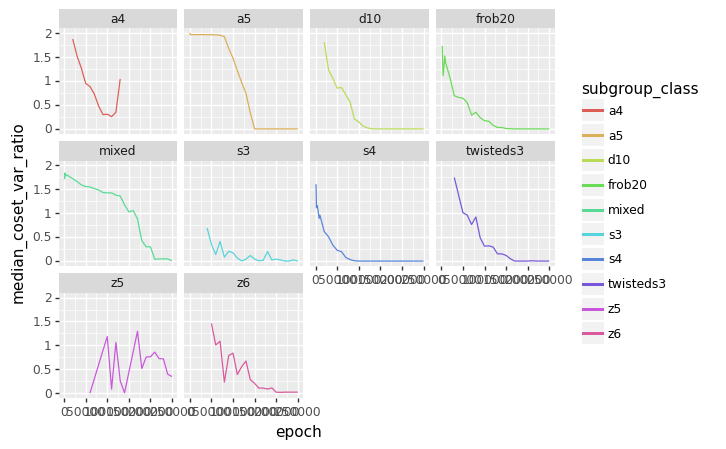

<ggplot: (694628316)>

In [297]:
ggplot(
    df,
    aes(
        x = 'epoch',
        y = 'median_coset_var_ratio',
        ymin = 'coset_var_ratio25',
        ymax = 'coset_var_ratio75',
        fill = 'subgroup_class',
        color='subgroup_class'
    )
) + facet_wrap('~subgroup_class') + geom_line()

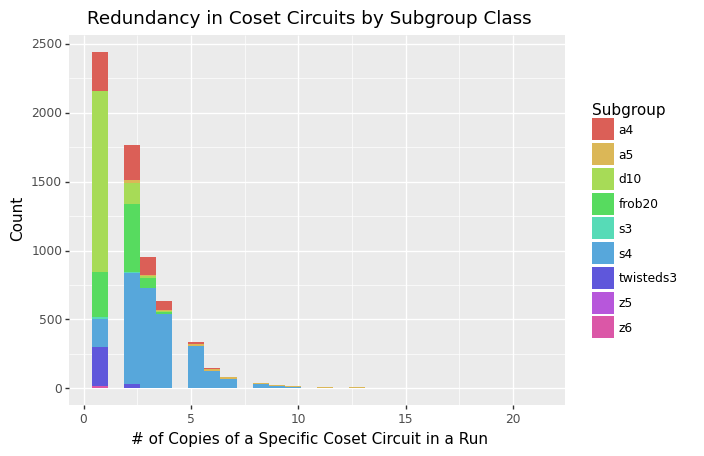

<ggplot: (689439243)>

In [362]:
df = (
    merged_df
    .filter(pl.col('epoch') == 249999)
    .filter(pl.col('coset_var_ratio') < 1.0)
    .filter(pl.col('subgroup_class') != 'mixed')
    .groupby(['seed', 'subgroup_class', 'subgroup_pair'])
    .agg(pl.count())
)

(
    ggplot(df, aes(x = 'count', fill = 'subgroup_class')) 
    + geom_histogram(binwidth=0.75)
    + labs(x = '# of Copies of a Specific Coset Circuit in a Run', y = 'Count', fill = 'Subgroup', title = 'Redundancy in Coset Circuits by Subgroup Class')
)

In [243]:
llinear_df, rlinear_df, unembed_df, power_df = fourier_stats(11)

In [245]:
power_df.filter(pl.col('variable') == 'dim88')

layer,irrep,variable,value
str,str,str,f32
"""left_linear""","""(1, 1, 1, 1, 1…","""dim88""",0.000002
"""left_linear""","""(2, 1, 1, 1)""","""dim88""",0.000014
"""left_linear""","""(2, 2, 1)""","""dim88""",0.000012
"""left_linear""","""(3, 1, 1)""","""dim88""",0.000034
"""left_linear""","""(3, 2)""","""dim88""",0.000024
"""left_linear""","""(4, 1)""","""dim88""",0.985349
"""left_linear""","""(5,)""","""dim88""",0.014565
"""right_linear""","""(1, 1, 1, 1, 1…","""dim88""",4.5266e-12
"""right_linear""","""(2, 1, 1, 1)""","""dim88""",0.000051


In [246]:
df88_left = (
    llinear_df
    .groupby('permutation')
    .agg(preacts=pl.col('dim88').sum())
    .join(full_right_coset_df.filter(pl.col('subgroup').str.starts_with('a4')), on='permutation')
)

df88_right = (
    rlinear_df
    .groupby('permutation')
    .agg(preacts=pl.col('dim88').sum())
    .join(full_left_coset_df.filter(pl.col('subgroup').str.starts_with('a4')), on='permutation')
)


In [249]:
df88_left.head()

permutation,preacts,subgroup,coset_rep
str,f32,str,str
"""(0, 1, 2, 3, 4…",4.251543,"""a4_0""","""(0, 1, 2, 3, 4…"
"""(0, 1, 3, 4, 2…",4.19844,"""a4_0""","""(0, 1, 2, 3, 4…"
"""(0, 1, 4, 2, 3…",4.252069,"""a4_0""","""(0, 1, 2, 3, 4…"
"""(0, 2, 1, 4, 3…",-3.74912,"""a4_0""","""(0, 1, 2, 3, 4…"
"""(0, 2, 3, 1, 4…",-3.754175,"""a4_0""","""(0, 1, 2, 3, 4…"


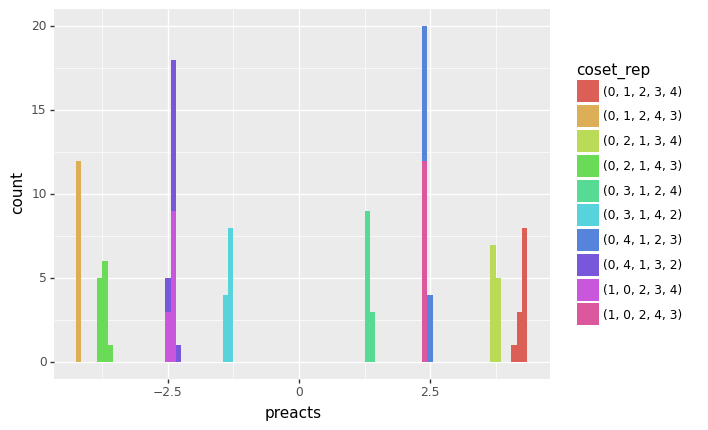

<ggplot: (691295662)>

In [251]:
sg = 1
(
    ggplot(
        df88_left.filter(pl.col('subgroup') == f'a4_{sg}'),
        aes(x = 'preacts', fill = 'coset_rep')
    )
    + geom_histogram(binwidth=0.1)
)

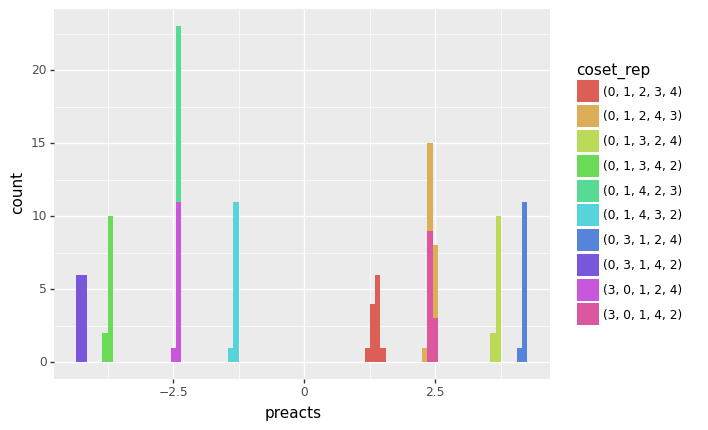

<ggplot: (372549413)>

In [257]:
sg = 3
(
    ggplot(
        df88_right.filter(pl.col('subgroup') == f'a4_{sg}'),
        aes(x = 'preacts', fill = 'coset_rep')
    )
    + geom_histogram(binwidth=0.1)
)

In [213]:
merged0, both0 = cosets_over_time(7)

In [215]:
merged0.filter(pl.col('subgroup_class') == 's3xs2')

epoch,layer,variable,left_subgroup,left_min_coset_var,left_mean_preactivation,min,left_min_preactivation,left_full_var,left_two_norm,left_coset_var_ratio,left_subgroup_class,layer_right,right_subgroup,right_min_coset_var,right_mean_preactivation,min_right,right_min_preactivation,right_full_var,right_two_norm,right_coset_var_ratio,right_subgroup_class,subgroup_pair,coset_var,coset_var_ratio,two_norm,subgroup_class
i64,str,str,str,f32,f32,f32,f32,f32,f32,f32,str,str,str,f32,f32,f32,f32,f32,f32,f32,str,str,f32,f32,f32,str
80000,"""left_linear""","""dim58""","""s3xs2_9""",26.159439,-0.067397,-5.729514,6.95602,14.54631,1731.556152,1.798356,"""s3xs2""","""right_linear""","""s3xs2_9""",10.444861,-0.048696,-5.24966,5.754246,13.609639,1619.832031,0.767461,"""s3xs2""","""(s3xs2_9, s3xs…",18.302151,1.282908,1675.694092,"""s3xs2"""
90000,"""left_linear""","""dim58""","""s3xs2_9""",19.449917,-0.080549,-5.88949,5.99918,14.973593,1782.63623,1.298948,"""s3xs2""","""right_linear""","""s3xs2_9""",7.999158,-0.073104,-5.163314,5.889448,14.36675,1710.28418,0.556783,"""s3xs2""","""(s3xs2_9, s3xs…",13.724538,0.927865,1746.460205,"""s3xs2"""
100000,"""left_linear""","""dim58""","""s3xs2_9""",15.323632,-0.02296,-5.909278,5.683478,16.219231,1930.151978,0.944782,"""s3xs2""","""right_linear""","""s3xs2_9""",5.86724,-0.082841,-5.384318,5.941888,16.01652,1906.789429,0.366324,"""s3xs2""","""(s3xs2_9, s3xs…",10.595436,0.655553,1918.470703,"""s3xs2"""
110000,"""left_linear""","""dim58""","""s3xs2_9""",14.176,0.043123,-6.167743,6.125372,17.599018,2094.506104,0.805499,"""s3xs2""","""right_linear""","""s3xs2_9""",4.721634,-0.022828,-5.786691,6.543193,17.222828,2049.579102,0.27415,"""s3xs2""","""(s3xs2_9, s3xs…",9.448816,0.539825,2072.04248,"""s3xs2"""
120000,"""left_linear""","""dim58""","""s3xs2_9""",14.2924,-0.011542,-6.571354,6.296471,19.017447,2263.091797,0.751541,"""s3xs2""","""right_linear""","""s3xs2_9""",4.775422,-0.000159,-6.001236,6.693977,18.771845,2233.849365,0.254393,"""s3xs2""","""(s3xs2_9, s3xs…",9.533911,0.502967,2248.470703,"""s3xs2"""
130000,"""left_linear""","""dim20""","""s3xs2_0""",9.149903,-0.266361,-4.886692,6.503676,11.160444,1336.606689,0.819851,"""s3xs2""","""right_linear""","""s3xs2_0""",18.983082,-0.4942,-6.118483,7.04597,11.04547,1343.718872,1.71863,"""s3xs2""","""(s3xs2_0, s3xs…",14.066492,1.269241,1340.162842,"""s3xs2"""
130000,"""left_linear""","""dim45""","""s3xs2_2""",22.493971,0.061129,-4.836559,5.196066,11.545407,1374.352173,1.948305,"""s3xs2""","""right_linear""","""s3xs2_9""",4.329961,0.129929,-5.552782,6.122554,12.672289,1510.027954,0.341687,"""s3xs2""","""(s3xs2_2, s3xs…",13.411966,1.144996,1442.190063,"""s3xs2"""
130000,"""left_linear""","""dim17""","""s3xs2_2""",15.229809,0.065505,-4.783784,6.71604,9.815942,1168.611816,1.551538,"""s3xs2""","""right_linear""","""s3xs2_9""",16.544222,0.023972,-5.362032,4.824189,9.268164,1102.980591,1.785059,"""s3xs2""","""(s3xs2_2, s3xs…",15.887015,1.668299,1135.796143,"""s3xs2"""
130000,"""left_linear""","""dim118""","""s3xs2_9""",11.131682,0.165891,-4.975421,5.688489,10.648034,1270.418579,1.045421,"""s3xs2""","""right_linear""","""s3xs2_7""",12.264299,-0.088452,-4.785831,5.68211,9.279283,1105.173462,1.321686,"""s3xs2""","""(s3xs2_9, s3xs…",11.69799,1.183554,1187.796021,"""s3xs2"""


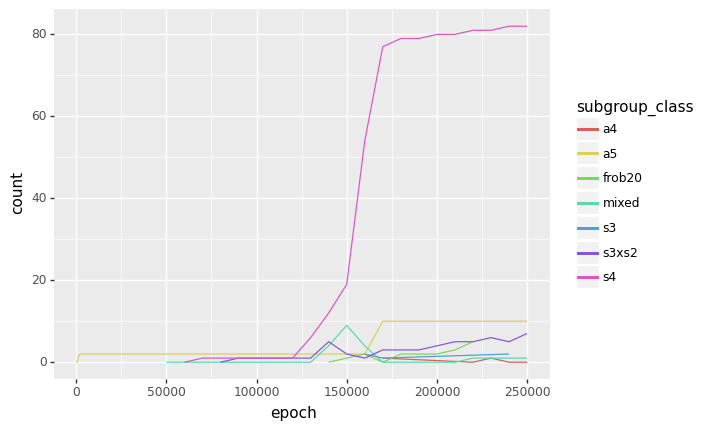

<ggplot: (689260986)>

In [217]:
from plotnine import scale_y_log10

df = (
    merged_df
    .groupby(['epoch', 'subgroup_class'])
    .agg(
        mean_two_norm = pl.col('two_norm').mean(),
        min_two_norm = pl.col('two_norm').min(),
        max_two_norm = pl.col('two_norm').max(),
        mean_coset_var_ratio = pl.col('coset_var_ratio').mean(),
        #log_coset_var_ratio = pl.col('coset_var_ratio').mean().log(),
        min_coset_var_ratio = pl.col('coset_var_ratio').min(),
        max_coset_var_ratio = pl.col('coset_var_ratio').max(),
        full_count = pl.count(),
        count = (pl.col('coset_var_ratio') < 1.0).sum()
    )
    .sort(['epoch', 'subgroup_class'])
)
ggplot(
    df,
    aes(
        x = 'epoch',
        y = 'count',
        color = 'subgroup_class')
) + geom_line()

In [78]:

"""
(
    linear_coset_df
    .groupby('subgroup_pair')
    .agg([
        pl.count(),
        pl.col('coset_var').mean(),
        pl.col('coset_var_ratio').mean(),
        pl.col('coset_var').min().suffix('_min'),
        pl.col('coset_var').max().suffix('_max'),
        pl.col('coset_var_ratio').min().suffix('_min'),
        pl.col('coset_var_ratio').max().suffix('_max'),
        pl.col('two_norm').mean(),
        (pl.col('two_norm') < 1.0).sum().alias('num_tiny'),
        (pl.col('two_norm') < 15.0).sum().alias('num_small')
    ]).sort('subgroup_pair')
)
"""
linear_coset_df.head()

variable,left_subgroup,left_min_coset_var,left_mean_preactivation,min,left_min_preactivation,left_full_var,left_two_norm,left_coset_var_ratio,left_subgroup_class,right_subgroup,right_min_coset_var,right_mean_preactivation,min_right,right_min_preactivation,right_full_var,right_two_norm,right_coset_var_ratio,right_subgroup_class,subgroup_pair,coset_var,coset_var_ratio,two_norm,subgroup_class
str,str,f32,f32,f32,f32,f32,f32,f32,str,str,f32,f32,f32,f32,f32,f32,f32,str,str,f32,f32,f32,str
"""dim93""","""a5_0""",3.8016e-8,0.000007,-1.671376,1.671549,2.816196,335.12738,1.3499e-8,"""a5""","""a5_0""",0.001393,-0.002718,-1.671691,1.671575,2.788444,331.825745,0.0005,"""a5""","""(a5_0, a5_0)""",0.000697,0.00025,333.476562,"""a5"""
"""dim102""","""a5_0""",0.231451,0.000084,-0.709306,0.709774,0.122205,14.542413,1.893958,"""a5""","""a5_0""",0.231134,-0.000156,-0.709388,0.709617,0.122003,14.518321,1.894499,"""a5""","""(a5_0, a5_0)""",0.231293,1.894229,14.530367,"""a5"""
"""dim8""","""a5_0""",2.5227e-14,1.0589e-11,-3.0799e-7,3.1268e-7,1.5306e-14,1.8214e-12,1.648231,"""a5""","""a5_0""",2.9042e-14,1.0940e-10,-2.7550e-7,3.0962e-7,1.7090e-14,2.0337e-12,1.699406,"""a5""","""(a5_0, a5_0)""",2.7135e-14,1.673818,1.9275e-12,"""a5"""
"""dim32""","""a5_0""",0.233722,0.000084,-0.712797,0.713259,0.123405,14.68522,1.893936,"""a5""","""a5_0""",0.233405,-0.000157,-0.712884,0.713085,0.123201,14.660967,1.894498,"""a5""","""(a5_0, a5_0)""",0.233563,1.894217,14.673094,"""a5"""
"""dim33""","""a5_0""",3.8886e-8,0.000007,-1.671209,1.6714,2.815616,335.05838,1.3811e-8,"""a5""","""a5_0""",0.001393,-0.002718,-1.671448,1.671346,2.787811,331.750336,0.0005,"""a5""","""(a5_0, a5_0)""",0.000696,0.00025,333.404358,"""a5"""


In [88]:
2 ** 1000

10715086071862673209484250490600018105614048117055336074437503883703510511249361224931983788156958581275946729175531468251871452856923140435984577574698574803934567774824230985421074605062371141877954182153046474983581941267398767559165543946077062914571196477686542167660429831652624386837205668069376

In [90]:
exp_dir = Path('/Users/dashiell/workspace/sn-grok/s5_40_small')




paths = sorted([fp for fp in exp_dir.glob('s5_40_0/*.pth')], key=fp_key)

In [97]:
ckpt0 = torch.load('/Users/dashiell/workspace/sn-grok/s5_40_small/s5_40_0/full_run.pth', map_location=torch.device('cpu'))

In [99]:
ckpt0['checkpoint_epochs']

[0,
 2,
 4,
 8,
 16,
 32,
 64,
 128,
 512,
 1024,
 2048,
 4096,
 8192,
 10000,
 20000,
 30000,
 40000,
 50000,
 60000,
 70000,
 80000,
 90000,
 100000,
 110000,
 120000,
 130000,
 140000,
 150000,
 160000,
 170000,
 180000,
 190000,
 200000,
 210000,
 220000,
 230000,
 240000]

In [52]:
right_perm_coset_df.groupby('subgroup').agg([pl.count(), pl.col('min_coset_var').mean()]).sort('subgroup')

subgroup,count,min_coset_var
str,u32,f32
"""a5_0""",12,0.039933
"""frob20_0""",15,0.000524
"""frob20_3""",15,0.000072
"""frob20_4""",13,0.000048
"""frob20_5""",12,0.000145
"""s4_0""",12,0.017821
"""s4_1""",12,0.019676
"""s4_2""",10,0.036945
"""s4_3""",10,0.035601


In [107]:
left_perm_coset_df = left_perm_coset_df.select(pl.exclude(['layer', 'sanity'])).rename({
    'subgroup': 'left_subgroup',
    'min_coset_var': 'left_min_coset_var',
})

right_perm_coset_df = right_perm_coset_df.select(pl.exclude(['layer', 'sanity'])).rename({
    'subgroup': 'right_subgroup',
    'min_coset_var': 'right_min_coset_var',
})

In [116]:
linear_coset_df = (
    left_perm_coset_df
    .join(right_perm_coset_df, on='variable', how='inner')
    .with_columns([
        ('(' + pl.col('left_subgroup') + ', ' + pl.col('right_subgroup') + ')').alias('subgroup_pair'),
        ((pl.col('left_min_coset_var') + pl.col('right_min_coset_var'))/ 2).alias('coset_var')
    ]).sort('subgroup_pair')
)
linear_coset_df.groupby('subgroup_pair').agg([pl.count(), pl.col('coset_var').mean()]).sort('count')

subgroup_pair,count,coset_var
str,u32,f32
"""(a4_3, a4_4)""",1,0.003119
"""(s4_0, s4_3)""",2,0.017964
"""(frob20_1, fro...",2,0.000026
"""(frob20_4, fro...",2,0.000328
"""(frob20_4, fro...",2,0.000074
"""(a4_2, a4_4)""",2,0.003119
"""(frob20_5, fro...",2,0.000026
"""(frob20_1, fro...",2,0.000316
"""(s4_1, s4_4)""",2,0.004579


In [80]:
from plotnine import geom_dotplot

df_left = (
    llinear_df
    .filter((pl.col('irrep') == '(3, 2)'))
    .join(frob_right_coset_df, on='permutation')
)

df_right = (
    rlinear_df
    .filter((pl.col('irrep') == '(3, 2)'))
    .join(frob_left_coset_df, on='permutation')
)




In [83]:
df_right.head()

layer,permutation,irrep,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,dim33,...,dim93,dim94,dim95,dim96,dim97,dim98,dim99,dim100,dim101,dim102,dim103,dim104,dim105,dim106,dim107,dim108,dim109,dim110,dim111,dim112,dim113,dim114,dim115,dim116,dim117,dim118,dim119,dim120,dim121,dim122,dim123,dim124,dim125,dim126,dim127,subgroup,coset_rep
str,str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,...,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,str,str
"""right_linear""","""(0, 1, 3, 4, 2...","""(3, 2)""",0.006882,4.057464,-2.206739,0.010841,-4.289482,-3.237722,-0.050637,-0.01471,-1.7615e-8,0.01364,0.007057,-0.150332,-0.015372,2.186669,-0.049615,-0.554121,0.548133,0.004062,-0.001372,0.014201,-0.268502,0.004001,-0.003255,-4.302774,-4.267099,0.003995,-0.014742,-3.240087,-0.268333,0.536571,0.267557,-0.023176,-0.370521,-0.004803,...,-0.004822,-0.273449,0.544868,0.013992,4.280837,4.21802,0.014369,-4.246798,-0.006351,-0.368739,-0.002207,-0.0145,0.004205,-4.242894,4.292915,0.014659,-0.011246,-0.150367,-0.004831,-0.556363,-0.049622,0.26684,0.028603,0.028469,-2.210442,0.266235,-0.538237,2.188267,-0.272615,0.02742,-0.303674,0.265815,0.014382,-0.011194,-0.014577,"""frob20_0""","""(0, 1, 3, 4, 2..."
"""right_linear""","""(0, 2, 4, 1, 3...","""(3, 2)""",-0.037603,-0.510325,2.242348,0.012491,0.539522,0.407217,-0.041672,0.037869,6.9398e-8,0.016964,0.02117,-0.15108,-0.017843,-2.222107,-0.040672,-2.247108,2.223311,-0.02367,0.000418,-0.03678,-0.269868,-0.023635,0.019024,0.541243,0.536768,-0.023651,-0.017586,0.407598,-0.269708,2.176932,0.268935,-0.034167,0.226574,-0.014371,...,-0.01438,-0.275064,2.209905,-0.036834,-0.538542,-0.530522,0.017549,0.534117,0.034558,0.225479,0.000673,0.037417,-0.022088,0.533925,-0.539909,0.016992,-0.013481,-0.151138,-0.01437,-2.256732,-0.040652,0.268042,0.041538,0.041608,2.246116,0.267636,-2.183012,-2.223598,-0.273919,0.041143,-1.231927,0.266899,-0.037679,-0.013487,0.036949,"""frob20_0""","""(0, 1, 3, 4, 2..."
"""right_linear""","""(0, 3, 1, 2, 4...","""(3, 2)""",0.010143,-2.07014,4.313056,0.018207,2.189115,1.651885,-0.001583,0.055646,8.7130e-9,0.024405,0.038649,-0.148956,-0.026223,-4.274526,-0.001417,2.284118,-2.260237,0.006364,0.001084,-0.054335,-0.266122,0.006416,-0.005263,2.19541,2.177217,0.006435,-0.025799,1.653124,-0.265701,-2.212847,0.264838,-0.007069,-0.029427,-0.026318,...,-0.026305,-0.271105,-2.24646,-0.053928,-2.184457,-2.152412,0.025736,2.166969,-0.009507,-0.029246,0.001743,0.05504,0.005752,2.165074,-2.190606,0.02603,-0.019813,-0.149066,-0.026287,2.294101,-0.00108,0.264506,0.008761,0.00892,4.320537,0.263929,2.219194,-4.277344,-0.270141,0.008272,1.252382,0.263046,-0.054901,-0.019865,0.054662,"""frob20_0""","""(0, 1, 3, 4, 2..."
"""right_linear""","""(0, 4, 2, 3, 1...","""(3, 2)""",-0.01495,2.106131,-0.546386,-0.00417,-2.225807,-1.68041,-0.028023,0.050516,-9.1096e-8,-0.006098,-0.005069,-0.153995,0.00613,0.541256,-0.027306,4.402717,-4.356461,-0.009286,-0.000655,-0.049179,-0.275045,-0.009346,0.008119,-2.232992,-2.214566,-0.009319,0.005927,-1.681707,-0.274763,-4.265129,0.274039,-0.009227,-0.626638,0.003442,...,0.003469,-0.280252,-4.330182,-0.049171,2.221492,2.188954,-0.006494,-2.20404,0.013741,-0.623577,-0.001055,0.049957,-0.008917,-2.201888,2.227732,-0.006277,0.004823,-0.154083,0.003461,4.42166,-0.027564,0.273533,0.010924,0.011153,-0.547218,0.272637,4.277411,0.541908,-0.279316,0.010546,2.413643,0.272224,-0.050063,0.004818,0.049781,"""frob20_0""","""(0, 1, 3, 4, 2..."
"""right_linear""","""(1, 0, 2, 4, 3...","""(3, 2)""",-0.010336,4.059891,-0.544168,0.027504,-4.291996,-3.239558,-0.00045,0.037673,3.3039e-8,0.036479,0.0088,-0.152333,-0.03987,0.538739,0.000318,-2.247093,2.22347,-0.006535,-0.001159,

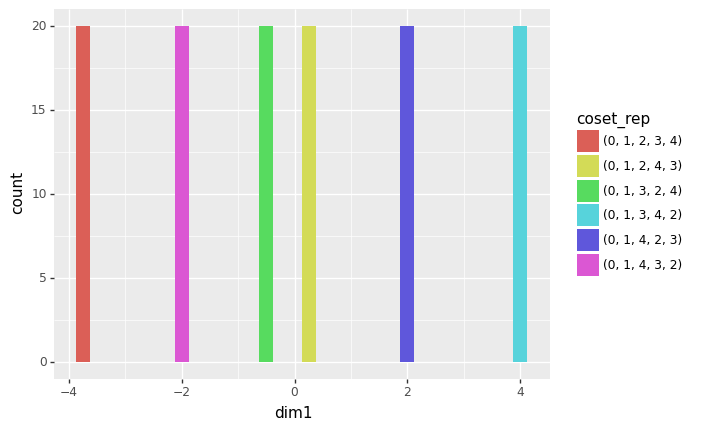

<ggplot: (691736622)>

In [91]:
coset = 4
# 123, 19, 18, 33, 3, 56
col = 'dim1'

#  geom_dotplot(binwidth=0.1, binpositions='all', stackgroups=True)
ggplot(df_right.filter(pl.col('subgroup') == f'frob20_{coset}'), aes(x = col, fill = "coset_rep")) + geom_histogram(binwidth=0.25)

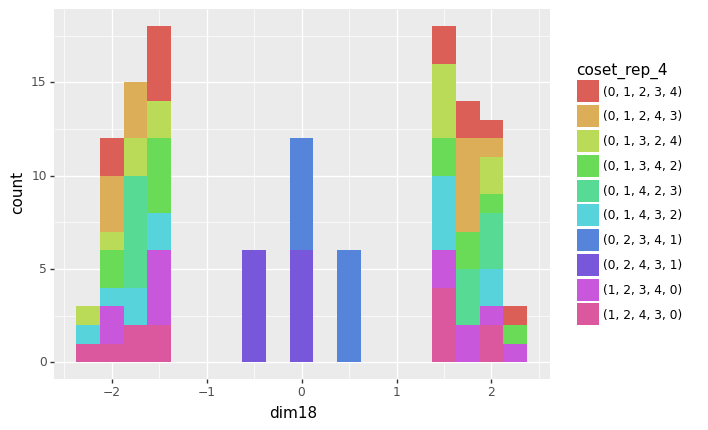

<ggplot: (710019574)>

In [187]:
coset = 4
# 123, 19, 18, 33, 3, 56
col = 'dim18'

#  geom_dotplot(binwidth=0.1, binpositions='all', stackgroups=True)
ggplot(df_left, aes(x = col, fill = f'coset_rep_{coset}')) + geom_histogram(binwidth=0.25)

In [195]:
ckpt_dir = Path('/Users/dashiell/workspace/sn-grok/s5_40_small')
run_name = f's5_40_7'

#whole_config = Config().from_disk('configs/s5_lr_5.toml')
run_dir = ckpt_dir / run_name
model_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
run_data = pl.read_parquet(run_dir / f'data.parquet')
lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()

model = SnMLP.from_config(model_run['config'])
model.load_state_dict(model_run['model'])

logits, cache = model.run_with_cache(lperms, rperms)


original_loss = loss_fn(logits, targets).mean()
    
linear_acts = cache['hook_linear']

linear_acts_df = pl.concat(
    [run_data, pl.DataFrame(linear_acts.detach().numpy(), schema=[f'dim{i}' for i in range(128)])],
    how='horizontal'
)


linear_acts_df.head()

permutation_left,permutation_right,permutation_target,index_left,index_right,index_target,in_train,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,…,dim91,dim92,dim93,dim94,dim95,dim96,dim97,dim98,dim99,dim100,dim101,dim102,dim103,dim104,dim105,dim106,dim107,dim108,dim109,dim110,dim111,dim112,dim113,dim114,dim115,dim116,dim117,dim118,dim119,dim120,dim121,dim122,dim123,dim124,dim125,dim126,dim127
str,str,str,i64,i64,i64,u8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""(0, 1, 2, 3, 4…","""(0, 1, 2, 3, 4…","""(0, 1, 2, 3, 4…",0,0,0,0,-5.4048e-35,9.7254e-34,-1.4585e-34,-2.6163e-34,0.793983,3.445494,4.3203e-35,2.159479,8.784583,-0.000334,1.5277e-33,-7.6824e-35,1.0233e-29,5.2146e-34,-1.233348,-0.000516,-8.3862e-35,0.000675,-2.7751e-34,1.589495,5.524645,-2.380452,-1.376954,-2.456835,0.0005,-2.510927,-2.5298e-26,-3.07365,2.8666e-35,-4.735275,…,10.837394,-3.075089,-8.866694,-4.972569,1.6400e-35,-1.637271,5.309939,-1.11593,2.514609,1.4504e-34,-2.376213,4.366046,-0.000183,-0.000286,-3.074142,5.776958,-4.0034e-16,-3.074549,-9.1601e-10,2.512307,3.1257e-34,3.0373e-34,-8.7928e-35,1.4787e-34,1.026566,-0.000042,5.440686,2.623858,-0.630295,1.874033,0.000036,0.000944,1.907442,0.001138,1.1363e-33,1.5200e-12,3.311396
"""(0, 1, 2, 3, 4…","""(0, 1, 3, 4, 2…","""(0, 1, 3, 4, 2…",0,1,1,1,1.2939e-33,2.7540e-34,-2.4510e-33,7.9404e-34,5.575815,3.445731,-1.1634e-34,2.159457,9.649538,-0.00065,1.2999e-37,-1.5765e-33,3.6779e-26,-5.1902e-34,6.19338,-3.896802,-4.3737e-34,-1.191763,-7.4705e-35,1.589327,7.52071,-2.380085,-1.377036,-2.456877,0.000179,1.347486,-2.4413e-26,-3.073699,-1.7289e-35,-7.224715,…,3.089146,-3.075087,-8.867555,-0.000568,4.7781e-35,0.000378,0.001183,-4.400392,0.000395,-1.9704e-34,0.001145,4.365889,0.000326,2.879695,-3.074145,5.776776,-2.9294e-16,-3.074578,-9.1618e-10,0.000303,7.8491e-34,2.3084e-33,-3.6606e-34,-3.2855e-35,-4.67418,2.468961,3.822044,0.000469,-0.629977,-2.92777,-6.245067,0.000372,3.191773,-6.355077,4.9990e-34,6.0697e-13,3.311658
"""(0, 1, 2, 3, 4…","""(0, 1, 4, 2, 3…","""(0, 1, 4, 2, 3…",0,2,2,1,2.0865e-33,-1.5691e-34,-3.9370e-33,7.9737e-34,-3.483204,3.445459,-3.8207e-34,2.160563,5.604283,-0.000386,1.7522e-33,-2.2866e-33,5.5711e-26,2.1254e-35,2.564,2.620499,-8.6749e-34,0.217073,-5.1212e-35,1.5892,1.354122,-2.380226,-1.37677,-2.456651,0.000366,-0.000357,-2.3122e-26,-3.073545,-4.1684e-35,-1.304696,…,7.824192,-3.074984,-8.866887,3.266674,2.5361e-34,3.138983,3.44803,-0.000596,3.813981,-1.1125e-33,-6.036894,4.366138,0.000061,-4.627254,-3.074035,5.777158,-2.4758e-16,-3.074516,-9.1599e-10,3.809982,-1.6422e-33,7.5334e-34,-5.9756e-34,4.0977e-34,-2.423145,6.165795,0.658792,-3.876454,-0.630055,-0.000355,-3.764735,0.000569,1.2218,-2.460717,8.3007e-34,9.1805e-13,3.311641
"""(0, 1, 2, 3, 4…","""(0, 2, 1, 4, 3…","""(0, 2, 1, 4, 3…",0,3,3,0,9.4321e-34,3.8127e-34,-2.0282e-33,-4.1884e-34,5.575428,8.464813,-4.3108e-34,2.15874,9.648479,-4.929662,1.1688e-34,-4.6351e-34,1.4812e-30,-8.0769e-34,2.564165,-3.896,-1.2091e-33,0.216824,1.1300e-35,1.589971,7.518509,4.672651,-4.716071,-5.410419,0.000034,-0.000399,8.2658e-27,-3.073434,-4.3692e-35,-7.224184,…,7.82374,-3.074832,-10.66352,-7.901401,3.2992e-34,3.678385,3.447791,-4.400736,0.000289,-1.1716e-33,0.0005,4.365342,2.90143,2.878928,-3.073873,5.777173,-4.0031e-16,-3.074312,3.1480e-13,0.000264,1.3255e-33,2.2820e-33,-6.8797e-34,6.7609e-34,-2.423883,4.864617,0.000406,-2.389576,-0.630331,-0.000385,-3.764714,0.000884,1.061531,-2.460767,-4.6661e-35,-1.0904e-13,3.311051
"""(0, 1, 2, 3, 4…","""(0, 2, 3, 1, 4…","""(0, 2, 3, 1, 4…",0,4,4,0,-2.6110e-34,9.7852e-34,4.6323e-35,1.0777e-33,0.79387,2.099363,-1.9892e-34,2.160378,8.784656,0.810224,3.6605e-33,-2.1213e-33,5.5714e-26,

In [199]:
def get_index_of(col_name, element):
    return (
        pl.col(col_name)
        .list.eval((pl.element() == element).cast(pl.UInt32))
        .list.arg_max().cast(pl.Utf8)
    )

S5 = Permutation.full_group(5)

perms = [str(p) for p in S5]
parities = ['odd' if p.parity else 'even' for p in S5]

parity_df = pl.DataFrame({'permutation': perms, 'parity': parities})

In [200]:
preacts_df = (
    linear_acts_df
    .join(parity_df, left_on='permutation_target', right_on='permutation', how='inner')
    .with_columns([
            pl.col('permutation_target').str.extract_all('([0-4])').alias('target_vals'),
    ])
    .with_columns([
        pl.col('target_vals').list.get(0).alias('val_at_index_0'),
        pl.col('target_vals').list.get(1).alias('val_at_index_1'),
        pl.col('target_vals').list.get(2).alias('val_at_index_2'),
        pl.col('target_vals').list.get(3).alias('val_at_index_3'),
        pl.col('target_vals').list.get(4).alias('val_at_index_4'),
        get_index_of('target_vals', '0').alias('index_of_0'),
        get_index_of('target_vals', '1').alias('index_of_1'),
        get_index_of('target_vals', '2').alias('index_of_2'),
        get_index_of('target_vals', '3').alias('index_of_3'),
        get_index_of('target_vals', '4').alias('index_of_4'),
        #pl.col(col).alias('activation')
    ])
)

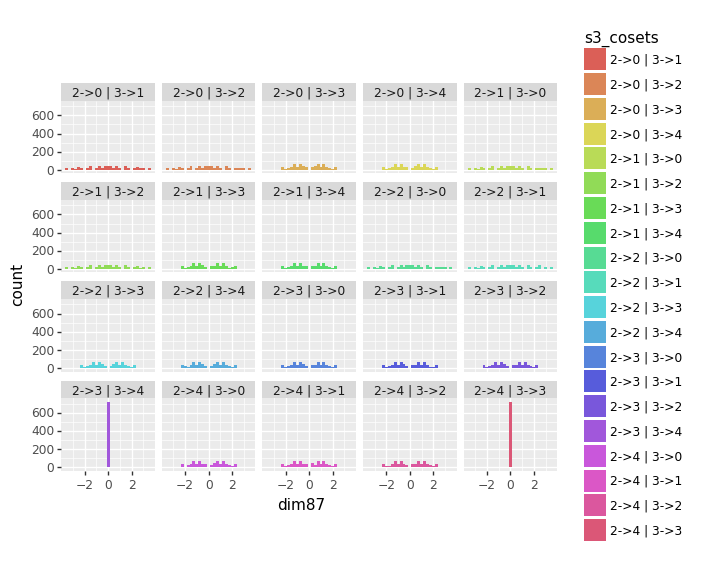

<ggplot: (372390330)>

In [259]:
idx0 = 2
idx1 = 3
# 123, 19, 18, 33, 3, 56
col = 'dim87'

df = preacts_df.with_columns(s3_cosets=(f'{idx0}->' + pl.col(f'index_of_{idx0}') + ' | ' + f'{idx1}->' + pl.col(f'index_of_{idx1}') ))

ggplot(
    df, 
    aes(x = col,
    fill = 's3_cosets')
) + geom_histogram(binwidth=0.25) + facet_wrap('~s3_cosets')

In [528]:
df_left = (
    llinear_df
    .filter((pl.col('irrep') == '(2, 1, 1, 1)'))
    .join(parity_df, on='permutation', how='inner')
    .with_columns([
            pl.col('permutation').str.extract_all('([0-4])').alias('target_vals'),
    ])
    .with_columns([
        pl.col('target_vals').arr.get(0).alias('val_at_index_0'),
        pl.col('target_vals').arr.get(1).alias('val_at_index_1'),
        pl.col('target_vals').arr.get(2).alias('val_at_index_2'),
        pl.col('target_vals').arr.get(3).alias('val_at_index_3'),
        pl.col('target_vals').arr.get(4).alias('val_at_index_4'),
        get_index_of('target_vals', '0').alias('index_of_0'),
        get_index_of('target_vals', '1').alias('index_of_1'),
        get_index_of('target_vals', '2').alias('index_of_2'),
        get_index_of('target_vals', '3').alias('index_of_3'),
        get_index_of('target_vals', '4').alias('index_of_4'),
        #pl.col(col).alias('activation')
    ])
)

df_right = (
    rlinear_df
    .filter((pl.col('irrep') == '(2, 1, 1, 1)'))
    .join(parity_df, on='permutation', how='inner')
    .with_columns([
            pl.col('permutation').str.extract_all('([0-4])').alias('target_vals'),
    ])
    .with_columns([
        pl.col('target_vals').arr.get(0).alias('val_at_index_0'),
        pl.col('target_vals').arr.get(1).alias('val_at_index_1'),
        pl.col('target_vals').arr.get(2).alias('val_at_index_2'),
        pl.col('target_vals').arr.get(3).alias('val_at_index_3'),
        pl.col('target_vals').arr.get(4).alias('val_at_index_4'),
        get_index_of('target_vals', '0').alias('index_of_0'),
        get_index_of('target_vals', '1').alias('index_of_1'),
        get_index_of('target_vals', '2').alias('index_of_2'),
        get_index_of('target_vals', '3').alias('index_of_3'),
        get_index_of('target_vals', '4').alias('index_of_4'),
        #pl.col(col).alias('activation')
    ])
)

In [559]:
from plotnine import scale_y_continuous, scale_x_continuous, theme_minimal, labs

coset = 1
# 123, 19, 18, 33, 3, 56
col = 'dim0'

left_perms = (
    ggplot(
        df_left, 
        aes(x = col, fill = f'val_at_index_{coset}', color=f'val_at_index_{coset}')
    ) 
    + geom_dotplot(binwidth=0.2, binpositions='all', stackgroups=True) 
    + scale_y_continuous(breaks=None)
    + theme_minimal()
    + labs(y = None, x = 'Left Permutation Preactivation', fill = 'Coset (Index of 1)', color = 'Coset (Index of 1)')
    
)

In [558]:
coset = 4
# 123, 19, 18, 33, 3, 56
col = 'dim0'

right_perms = (
    ggplot(
        df_right, 
        aes(x = col, fill = f'index_of_{coset}', color=f'index_of_{coset}')
    ) 
    + geom_dotplot(binwidth=0.2, binpositions='all', stackgroups=True, stackdir='center') 
    + scale_y_continuous(breaks=None)
    + labs(color='Coset (Index of 4)', fill = 'Coset (Index of 4)', y=None, x='Right Permutation Preactivation')
    + theme_minimal()
    
)

In [544]:
preacts_df.head()

permutation_left,permutation_right,permutation_target,index_left,index_right,index_target,in_train,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,...,dim103,dim104,dim105,dim106,dim107,dim108,dim109,dim110,dim111,dim112,dim113,dim114,dim115,dim116,dim117,dim118,dim119,dim120,dim121,dim122,dim123,dim124,dim125,dim126,dim127,parity,target_vals,val_at_index_0,val_at_index_1,val_at_index_2,val_at_index_3,val_at_index_4,index_of_0,index_of_1,index_of_2,index_of_3,index_of_4
str,str,str,i64,i64,i64,u8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,...,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,str,list[str],str,str,str,str,str,str,str,str,str,str
"""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...",0,0,0,1,-3.775655,-1.767592,4.355852,4.111899,3.517007,1.410858,3.370195,-0.002002,-3.3831e-8,3.363332,-0.0002,-0.934809,3.97328,1.958984,-1.674349,1.920292,-0.000007,0.771,0.002141,3.410779,0.817648,0.771271,-2.333777,0.000256,4.300687,0.771408,-1.506821,1.412014,2.803263,4.38824,...,0.003445,-6.125187,-1.128799,8.255993,-3.520589,-0.000898,-2.720912,-0.935056,3.342669,-1.698712,0.000324,3.544459,-0.001003,-9.539651,-0.000851,-0.809453,0.000502,4.022834,0.00078,-2.205838,-3.645307,-2.773485,6.116683,-2.720226,-8.513103,"""even""","[""0"", ""1"", ... ""4""]","""0""","""1""","""2""","""3""","""4""","""0""","""1""","""2""","""3""","""4"""
"""(0, 1, 2, 3, 4...","""(0, 1, 3, 4, 2...","""(0, 1, 3, 4, 2...",0,1,1,0,-8.352973,6.128013,1.883399,4.112237,-4.830398,-4.889877,2.409234,5.262263,-9.3724e-8,3.363966,-0.00043,-1.39209,3.971798,4.408011,-2.61375,3.610363,-1.673557,-2.081377,-0.000401,-1.733583,0.000825,-2.0817,0.000029,-8.372513,-4.002901,-2.082013,-1.506629,-4.893286,1.987334,2.750452,...,-0.000645,-0.909551,-3.853227,-0.001187,4.833428,-0.000575,-2.720825,-1.392542,3.342562,-0.000475,-0.943169,4.356119,0.000508,-9.540128,-2.47641,-0.000452,1.64337,6.474334,-0.827242,-2.207636,-2.718409,-1.966163,0.909722,-2.720075,-3.343327,"""even""","[""0"", ""1"", ... ""2""]","""0""","""1""","""3""","""4""","""2""","""0""","""1""","""4""","""2""","""3"""
"""(0, 1, 2, 3, 4...","""(0, 1, 4, 2, 3...","""(0, 1, 4, 2, 3...",0,2,2,0,-1.877807,4.17584,3.54388,4.112227,-2.765872,-3.332563,8.509821,6.17964,1.1265e-8,3.364374,-0.000657,0.000097,3.971361,2.763032,3.350292,4.43696,-2.491367,1.953474,0.000292,-2.633646,2.486914,1.953875,-3.301216,-6.30288,-1.950286,1.95421,-1.507692,-3.334889,4.47311,1.949587,...,0.000469,0.000199,-0.000032,2.040124,2.768884,-0.000287,-2.72138,0.000027,3.342789,0.829193,5.049911,1.884051,0.000293,-9.54,-0.812995,-2.46572,2.446318,4.827237,1.69467,-2.206436,-2.264988,-4.425918,0.00069,-2.720561,-2.439587,"""even""","[""0"", ""1"", ... ""3""]","""0""","""1""","""4""","""2""","""3""","""0""","""1""","""3""","""4""","""2"""
"""(0, 1, 2, 3, 4...","""(0, 2, 1, 4, 3...","""(0, 2, 1, 4, 3...",0,3,3,0,-8.3527,-1.767099,4.356258,4.112339,3.51669,1.410615,0.172352,6.177874,-1.6761e-7,3.362907,-0.000016,-2.505215,3.972086,1.958751,-4.797577,8.568703,-6.578782,-2.082141,0.002001,-2.630355,-1.98739,-2.082396,0.000202,-0.000159,4.300662,-2.082659,-1.506696,1.411745,0.000022,-2.052518,...,0.003219,-0.001071,-3.853646,8.255783,-3.519717,-0.000879,-2.720855,-2.505965,3.34255,4.977879,-3.141994,6.333035,2.226625,-7.301528,-0.000841,1.970553,6.460036,4.023306,-2.843801,0.002369,-0.000579,0.000374,0.001918,-2.720211,-2.441924,"""even""","[""0"", ""2"", ... ""3""]","""0""","""2""","""1""","""4""","""3""","""0""","""2""","""1""","""4""","""3"""
"""(0, 1, 2, 3, 4...","""(0, 2, 3, 1, 4...","""(0, 2, 3, 1, 4...",0,4,4,1,-3.77538,4.177586,3.54405,4.112895,-2.767575,-3.333015,0.000009,5.265954,-2.7721e-8,3.363995,0.044699,-3.677078,3.970941,2.762717,-4.967926,-0.000261,1.900325,0.770893,0.000394

In [557]:
coset = 4
all_perms = (
    ggplot(
        preacts_df, 
        aes(x = col, fill = f'index_of_{coset}')
    ) 
    + geom_histogram(binwidth=0.5)
    + labs(x = 'Full Preactivations', y = '# of Permutations', fill = 'Coset (Index of 4)')
    + theme_minimal()
)




In [562]:
import patchworklib as pw

p_left = pw.load_ggplot(left_perms, figsize = (2, 2))
p_right = pw.load_ggplot(right_perms, figsize = (2, 2))
p_full = pw.load_ggplot(all_perms, figsize = (4, 4))


PlotnineError: "Could not evaluate the 'x' mapping: 'dim0' (original error: name 'dim0' is not defined)"

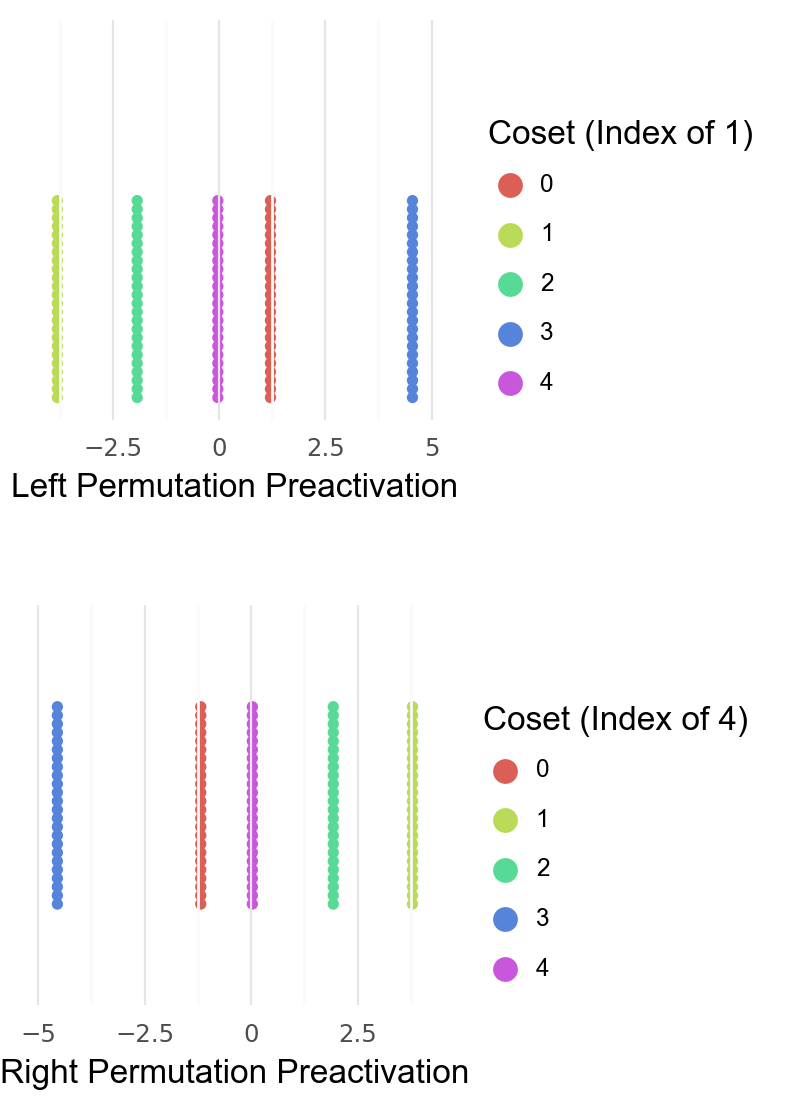

In [564]:
p_left / p_right

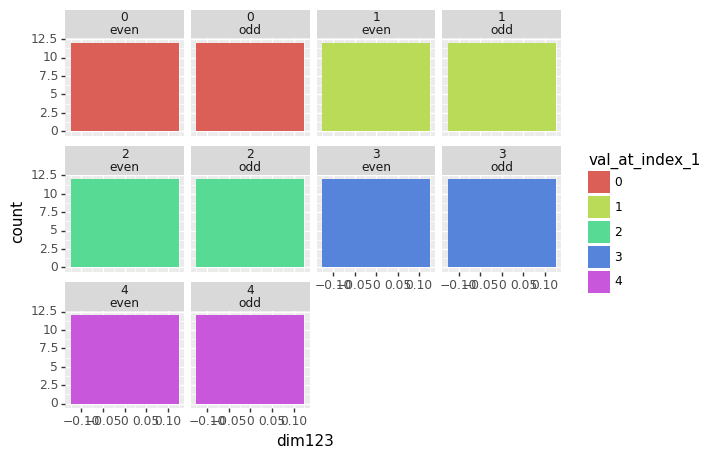

<ggplot: (711382779)>

In [489]:
coset = 1
# 123, 19, 18, 33, 3, 56
col = 'dim123'

ggplot(
    df_right,
    aes(x = col,
    fill = f'val_at_index_{coset}')) + geom_histogram(binwidth=0.25) + facet_wrap(f'~val_at_index_{coset}+parity')

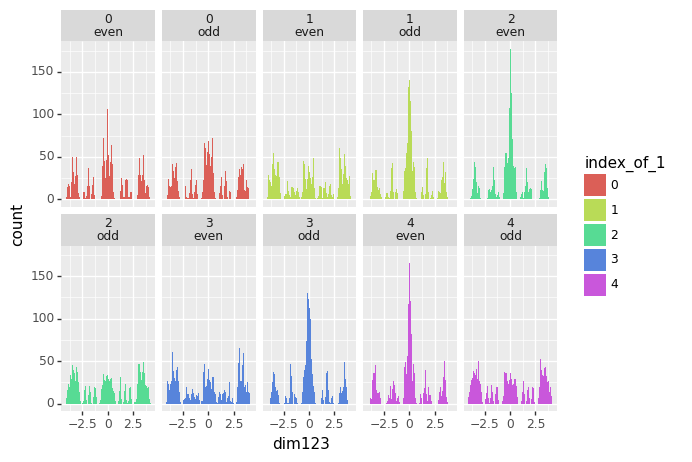

<ggplot: (705860188)>

In [262]:
coset = 1
# 123, 19, 18, 33, 3, 56
col = 'dim123'

ggplot(
    preacts_df, 
    aes(x = col,
    fill = f'index_of_{coset}')) + geom_histogram(binwidth=0.1) + facet_wrap(f'~index_of_{coset}+parity', ncol=5)

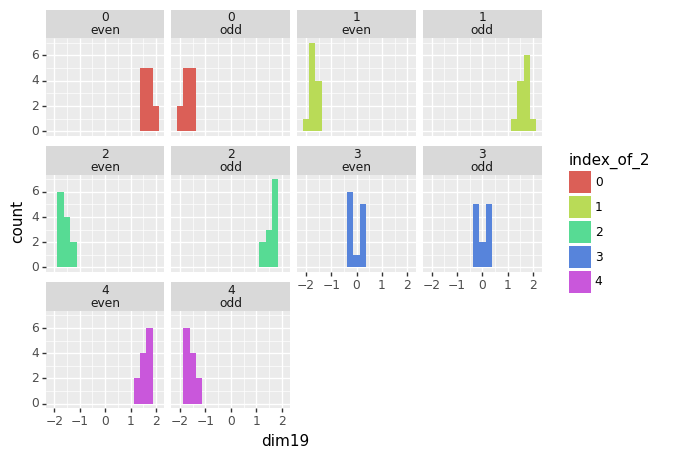

<ggplot: (706154614)>

In [271]:
coset = 2
# 123, 19, 18, 33, 3, 56
col = 'dim19'

ggplot(
    df_left, 
    aes(x = col,
    fill = f'index_of_{coset}')
) + geom_histogram(binwidth=0.25) + facet_wrap(f'~index_of_{coset}+parity')

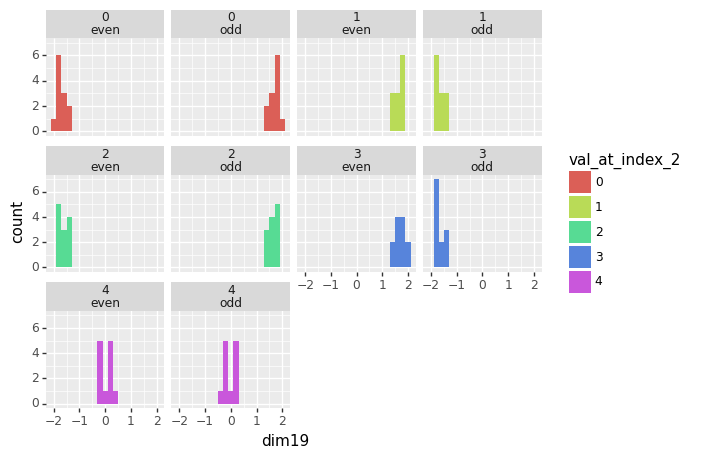

<ggplot: (704855737)>

In [277]:
coset = 2
# 123, 19, 18, 33, 3, 56
col = 'dim19'

ggplot(
    df_right, 
    aes(x = col,
    fill = f'val_at_index_{coset}')) + geom_histogram(binwidth=0.2) + facet_wrap(f'~val_at_index_{coset}+parity')

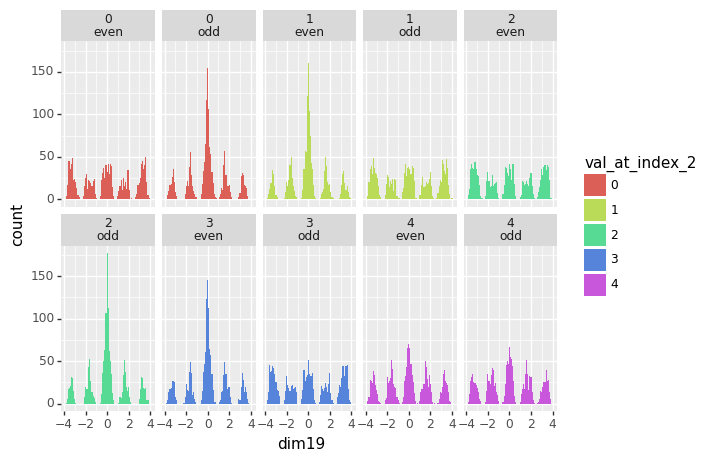

<ggplot: (711317679)>

In [279]:
coset = 2
# 123, 19, 18, 33, 3, 56
col = 'dim19'

ggplot(
    preacts_df, 
    aes(x = col,
    fill = f'val_at_index_{coset}')) + geom_histogram(binwidth=0.1) + facet_wrap(f'~val_at_index_{coset}+parity', ncol=5)

In [280]:
df2111_left = (
    llinear_df
    .filter((pl.col('irrep') == '(2, 1, 1, 1)'))
    .join(parity_df, on='permutation', how='inner')
    .with_columns([
            pl.col('permutation').str.extract_all('([0-4])').alias('target_vals'),
    ])
    .with_columns([
        pl.col('target_vals').arr.get(0).alias('val_at_index_0'),
        pl.col('target_vals').arr.get(1).alias('val_at_index_1'),
        pl.col('target_vals').arr.get(2).alias('val_at_index_2'),
        pl.col('target_vals').arr.get(3).alias('val_at_index_3'),
        pl.col('target_vals').arr.get(4).alias('val_at_index_4'),
        get_index_of('target_vals', '0').alias('index_of_0'),
        get_index_of('target_vals', '1').alias('index_of_1'),
        get_index_of('target_vals', '2').alias('index_of_2'),
        get_index_of('target_vals', '3').alias('index_of_3'),
        get_index_of('target_vals', '4').alias('index_of_4'),
        #pl.col(col).alias('activation')
    ])
)

df2111_right = (
    rlinear_df
    .filter((pl.col('irrep') == '(2, 1, 1, 1)'))
    .join(parity_df, on='permutation', how='inner')
    .with_columns([
            pl.col('permutation').str.extract_all('([0-4])').alias('target_vals'),
    ])
    .with_columns([
        pl.col('target_vals').arr.get(0).alias('val_at_index_0'),
        pl.col('target_vals').arr.get(1).alias('val_at_index_1'),
        pl.col('target_vals').arr.get(2).alias('val_at_index_2'),
        pl.col('target_vals').arr.get(3).alias('val_at_index_3'),
        pl.col('target_vals').arr.get(4).alias('val_at_index_4'),
        get_index_of('target_vals', '0').alias('index_of_0'),
        get_index_of('target_vals', '1').alias('index_of_1'),
        get_index_of('target_vals', '2').alias('index_of_2'),
        get_index_of('target_vals', '3').alias('index_of_3'),
        get_index_of('target_vals', '4').alias('index_of_4'),
        #pl.col(col).alias('activation')
    ])
)

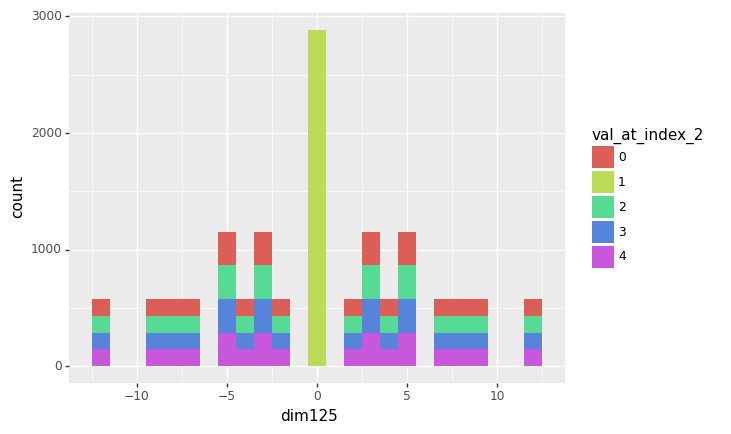

<ggplot: (708607883)>

In [302]:
coset = 2
# 8, 125, 59
col = 'dim125'

ggplot(
    preacts_df, 
    aes(x = col,
    fill = f'val_at_index_{coset}')) + geom_histogram(binwidth=1) 